In [1]:
from loadmodules import *
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import matplotlib.colors as mcolors
import scipy as sp
from sklearn.mixture import GaussianMixture

%matplotlib inline
rcParams['figure.facecolor'] = 'white'
# plt.rcParams.update({
#     "text.usetex": True
# })

In [2]:
# path = './Auriga_SC/K12_fiducial/'
path = './'
simulation_list = [directory for directory in os.listdir(path) if 'Au6_lvl4_cfea' in directory]
print(simulation_list)

['Au6_lvl4_cfea_emosaics', 'Au6_lvl4_cfea_sh50myr10', 'Au6_lvl4_cfea_compressive', 'Au6_lvl4_cfea_sh50myr50', 'Au6_lvl4_cfea_scbase', 'Au6_lvl4_cfea_fiducial']


# ICMF sampling test

In [3]:
sim_id = 1
snap_id = 127
print('Loading simulation ', simulation_list[sim_id], ' snapshot ', snap_id)
sf = load_subfind(snap_id, dir=path+simulation_list[sim_id]+'/output/', hdf5=True, loadonly=['fpos', 'fmm2', 'frc2', 'svel', 'flty', 'fnsh', 'slty', 'spos', 'smty', 'ffsh'] )
s = gadget_readsnap(snap_id, snappath=path+simulation_list[sim_id]+'/output/', subfind=sf, hdf5=True, applytransformationfacs=True, loadonlyhalo=0)
s.calc_sf_indizes( sf )
galrad = 0.75 * sf.data['frc2'][0]
s.select_halo( sf, use_principal_axis=True, use_cold_gas_spin=False, do_rotation=True )

Loading simulation  Au6_lvl4_cfea_sh50myr10  snapshot  127
galrad= 0.021391647
Found 1370901 stars.
Rotated pos.
Rotated bfld.
Rotated vel.


array([[-0.05904483,  0.35439216,  0.93323089],
       [ 0.49324374, -0.80241338,  0.3359217 ],
       [ 0.86788497,  0.48014474, -0.12742336]])

In [4]:
solar_mass_g = 1.989e33
Gcosmo = 43.
k = 1.3807e-16 # boltzmann constant in erg/K (g*cm^2/s^2/K)
parsec = 3.08567758e18 # cm
gyr = 3.15576e16 # seconds

s.parameters['UnitTime_in_s'] = s.parameters['UnitLength_in_cm']/s.parameters['UnitVelocity_in_cm_per_s']

In [5]:
starparts = (s.data['age'] > 0) * (s.r()[s.data['type']==4]<galrad)
mask_cluster_initial = (s.data['incl'][starparts]>0)
mask_cluster_final = (s.data['nclt'][starparts]>0)
imclus = s.data['imcl'][starparts][mask_cluster_initial].flatten()*s.UnitMass_in_g/solar_mass_g
imtotclus = s.data['imfc'][starparts][mask_cluster_initial]*s.data['mass'][s.data['type']==4][starparts][mask_cluster_initial]*s.UnitMass_in_g/solar_mass_g
inclus = s.data['incl'][starparts][mask_cluster_initial].flatten()
mtrunc = s.data['mtrc'][starparts][mask_cluster_initial] * s.UnitMass_in_g/solar_mass_g

In [6]:
mask_problematic = s.data['imfc']>1.
print('Problematic stars with clusters {:4d}'.format(mask_problematic.sum()))
print('That`s {:.3f} per cent of stars with clusters'.format(mask_problematic.sum()/len(s.data['imfc'][s.data['incl']>0]) * 100))

Problematic stars with clusters 7083
That`s 9.835 per cent of stars with clusters


In [7]:
stars_age = s.cosmology_get_lookback_time_from_a(s.data['age'][starparts], is_flat=True) - s.cosmology_get_lookback_time_from_a(s.time, is_flat=True)

In [8]:
def ICMF(norm, m, mtrunc):
    icmf = norm*np.exp(-m/mtrunc)/m**2
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            icmf[mask] = norm[mask] * np.exp(-1e3/mtrunc)/(1e3**2)
        else:
            icmf[mask] = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    else:
        if m < 1e3:
            icmf = norm * np.exp(-1e3/mtrunc)/(1e3**2)
    return icmf

def mICMF(norm, m, mtrunc):
    micmf = norm*np.exp(-m/mtrunc)/m
    if type(m) == np.ndarray:
        mask = m < 1e3
        if type(norm) == np.ndarray:
            micmf[mask] = norm[mask]*np.exp(-1e3/mtrunc)/1e3
        else:
            micmf[mask] = norm*np.exp(-1e3/mtrunc)/1e3
    else:
        if m < 1e3:
            micmf = norm*np.exp(-1e3/mtrunc)/1e3
    return micmf

def trapz_log(norm, min, max, mtrunc, IMF, n):
    integral = 0.
    h = (np.log10(max) - np.log10(min))/n
    low = np.log10(min)
    for i in range(n):
        current = 10**(low + i*h)
        next = 10**(low + (i+1)*h)
        dx = abs(current - next)
        integral += 0.5*dx*(IMF(norm, current, mtrunc) + IMF(norm, next, mtrunc))
    return integral

In [9]:
nbins = 25
min_gcmf = 5e3 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.logspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(np.log10(marray_gcmf))

N,_ = np.histogram(imclus[imclus>0], bins=marray_gcmf, density=True)
initial_population = N/width

In [10]:
norm = 1/trapz_log(1., min_gcmf, max_gcmf, mtrunc, ICMF, 500)
norm_real = 1/trapz_log(1., 1e2, max_gcmf, mtrunc, ICMF, 500)

In [11]:
mean_mclus = trapz_log(norm_real, 1e2, max_gcmf, mtrunc, mICMF, 500)
nexp_clus = (s.data['lcfe'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10)/mean_mclus

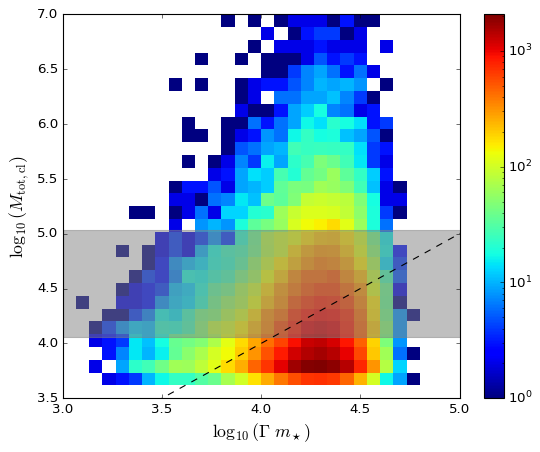

In [12]:
cb = plt.hist2d(np.log10(s.data['lcfe'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10),
           np.log10(s.data['imfc'][starparts][mask_cluster_initial]*s.data['gima'][starparts][mask_cluster_initial]*1e10), range=([3,5], [3.5,7]), bins=(30,30),rasterized=True, norm=mcolors.LogNorm())
plt.plot(np.linspace(3,7, 50), np.linspace(3,7, 50), 'k--')
plt.fill_betweenx([np.unique(np.log10(1e10*s.data['gima'][starparts][mask_cluster_initial]))[0],np.unique(np.log10(1e10*s.data['gima'][starparts][mask_cluster_initial]))[-1]],\
                   3, 5, where=[True,True], color='grey', alpha=0.5)
plt.xlim(3,5)
plt.ylim(3.5,7)
plt.xlabel(r'$\log_{10} ( \Gamma \; m_\star)$', fontsize=16)
plt.ylabel(r'$\log_{10} ( M_{\rm{tot,cl}})$', fontsize=16)
plt.colorbar(cb[3])

In [13]:
ICMF_array=[]

for i in range(len(mtrunc)):
    ICMF_array.append(ICMF(norm[i], marray_gcmf, mtrunc[i]))

ICMF_array = np.array(ICMF_array)

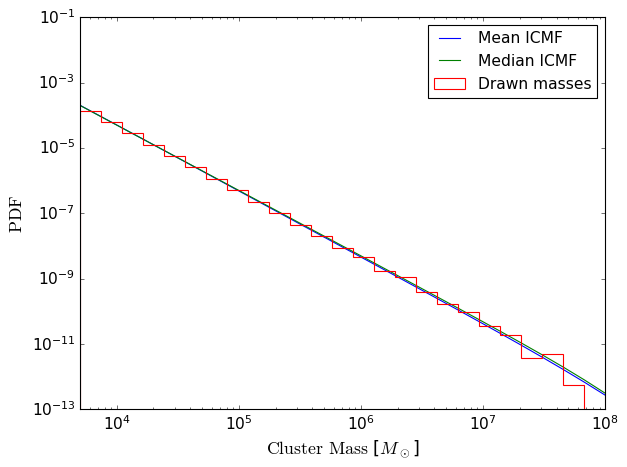

In [14]:
plt.loglog(marray_gcmf, np.nanmean(ICMF_array,axis=0), label='Mean ICMF')
plt.loglog(marray_gcmf, np.nanmedian(ICMF_array,axis=0), label='Median ICMF')
# plt.hist(imtotclus/inclus, bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
plt.hist(imclus[imclus>0], bins=marray_gcmf, density=True, histtype='step', label='Drawn masses')
# plt.step(marray_gcmf[:-1], initial_population, where='post', label='Initial Population')
plt.legend(fontsize=14)
# plt.ylim(1e-13, 1e-1)
plt.xlim(min_gcmf, max_gcmf)
plt.xlabel(r'$\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.yticks(np.logspace(-13, -1, 7))
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tight_layout()
# plt.savefig('plots/icmf_sampling_test_consistent.pdf')

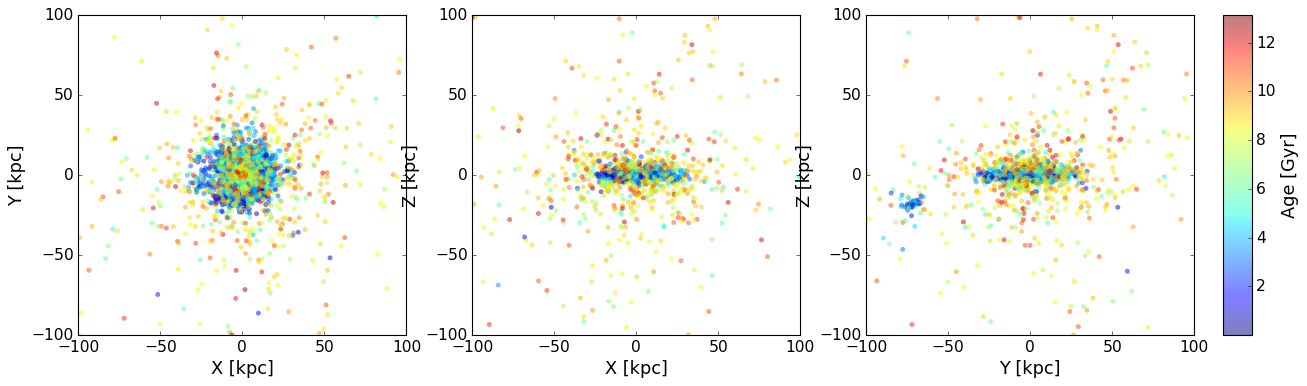

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0],
                 c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

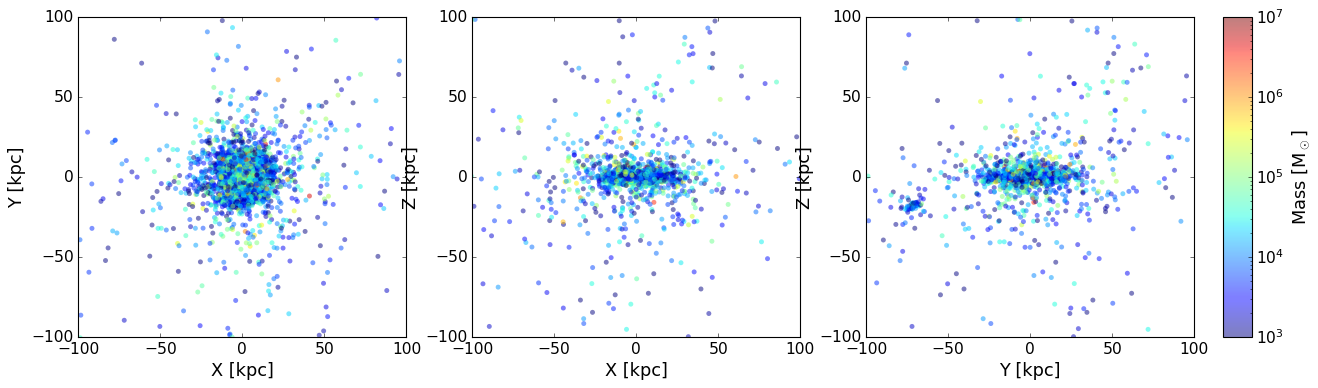

In [16]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[0].set_xlim(-100,100)
ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[1].set_xlim(-100,100)
ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0], 
              c=(1e10*s.data['mass'][s.data['type']==4][starparts]*s.data['mfcl'][starparts])[mask_cluster_final], norm=mcolors.LogNorm(vmin=1e3, vmax=1e7), alpha=0.5, linewidth=0)
ax[2].set_xlim(-100,100)
ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label('Mass [M$_\odot$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_mass_distribution.pdf')

In [17]:
mclus = s.data['mclt'][starparts][mask_cluster_final].flatten()
mclus = mclus[mclus>0]
nclus = s.data['nclt'][starparts][mask_cluster_final]

In [18]:
kinetic_energy = np.sum(s.data['vel']**2, axis=1)

orbital_energy = s.data['pot'] + 0.5 * kinetic_energy
orbital_energy /= 1e5

J_mod = np.sqrt((np.cross(s.data['pos'], s.data['vel'])**2).sum(axis=1))
Lz = np.cross( s.data['pos'], (s.data['vel'] ) )[:,0]

parts_radius = s.r()
isort_parts = np.argsort(parts_radius)
revert_sort = np.argsort(isort_parts)
cummass = np.cumsum(s.data['mass'][isort_parts])
Vc_parts = np.sqrt(Gcosmo*cummass[revert_sort]/parts_radius)

Ecirc = 0.5*Vc_parts[isort_parts]**2 + s.data['pot'][isort_parts]
Ecirc /= 1e5
e_max = np.nanmax(Ecirc[~np.isinf(Ecirc)])
orbital_energy -= e_max
Ecirc -= e_max

In [19]:
def mask_equal_to_previous(arr):
    mask = np.ones(len(arr), dtype=bool)
    mask[1:] = arr[1:] != arr[:-1]
    return mask

# Example usage
mask = mask_equal_to_previous(parts_radius[isort_parts][~np.isinf(Ecirc)])

In [20]:
r_test = np.logspace(-5, np.log10(parts_radius.max()), 500)
Ecirc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask])
Vc_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Vc_parts[isort_parts][~np.isinf(Ecirc)][mask])
Mr_f = sp.interpolate.PchipInterpolator(parts_radius[isort_parts][~np.isinf(Ecirc)][mask], cummass[~np.isinf(Ecirc)][mask])

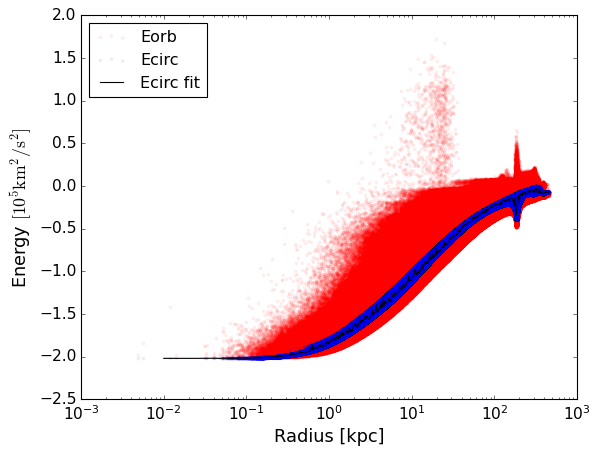

In [21]:
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], orbital_energy[isort_parts][~np.isinf(Ecirc)][mask], c='r', edgecolors='face', label='Eorb', s=5, alpha=0.05)
plt.scatter(1e3*parts_radius[isort_parts][~np.isinf(Ecirc)][mask], Ecirc[~np.isinf(Ecirc)][mask], edgecolors='face', label='Ecirc', s=5, alpha=0.05)
plt.plot(1e3*r_test, Ecirc_f(r_test), c='k', label='Ecirc fit')
plt.legend(loc='upper left')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Energy $[10^5 \rm{km}^2/\rm{s}^2]$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

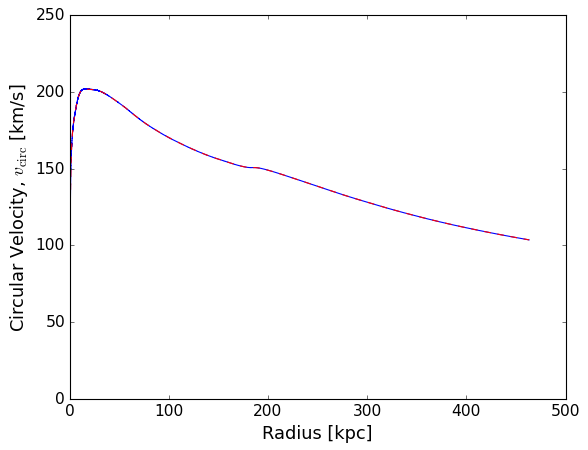

In [22]:
plt.plot(1e3*parts_radius[isort_parts], Vc_parts[isort_parts])
plt.plot(1e3*r_test, Vc_f(r_test), 'r--')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Circular Velocity, $v_{\rm{circ}}$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.tick_params(axis='both', which='both', labelsize=14)

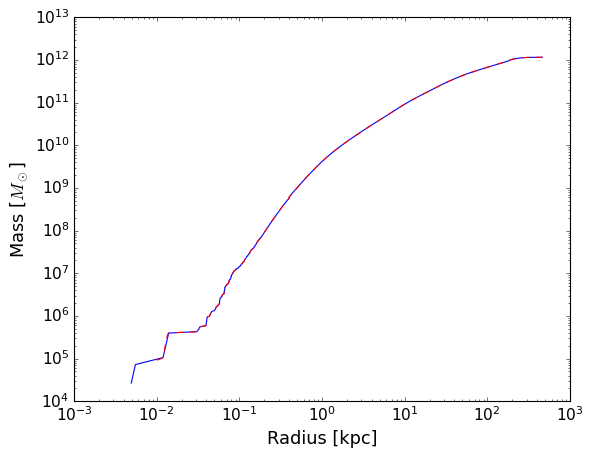

In [23]:
plt.plot(1e3*parts_radius[isort_parts], 1e10*cummass)
plt.plot(1e3*r_test, 1e10*Mr_f(r_test), 'r--')
plt.yscale('log')
plt.xscale('log')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel(r'Mass [$M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [24]:
def velocity_dispersion(radius, parts_radius, starparts, s_data_age, s_data_vel, s_data_type):
    # Select particles within the given radius
    within_radius = parts_radius[starparts][s_data_age > 0.] < radius
    if within_radius.sum() >= 48:
        velocities = np.sqrt(np.sum(s_data_vel[starparts][s_data_age > 0.][within_radius]**2, axis=1))
    # if not enough stars, use dark matter particles
    else:
        mask_dm = (s_data_type != 4) * (s_data_type != 0)
        within_radius = parts_radius[mask_dm] < radius
        velocities = np.sqrt(np.sum(s_data_vel[mask_dm][within_radius]**2, axis=1))

    # Calculate the velocity dispersion
    if velocities.size == 0:
        return 0.0
    # Avoid division by zero
    else:
        return np.std(velocities)

def B(x):
    return sp.special.erf(x) * 2.*x*np.exp(-x**2)/np.sqrt(np.pi)

In [25]:
idx = np.argmin(np.abs(orbital_energy[s.data['type']==4][starparts][mask_cluster_final][:,np.newaxis] - Ecirc_f(r_test)), axis=1)
rc_clus = r_test[idx]
vc_rc_clus = Vc_f(rc_clus)
M_rc_clus = Mr_f(rc_clus)
# sigma_rc_clus = np.array([velocity_dispersion(rc, parts_radius, starparts, s.data['age'], s.data['vel'], s.data['type']) for rc in rc_clus])

rc_clus = np.repeat(rc_clus, nclus)
M_rc_clus = np.repeat(M_rc_clus, nclus)
vc_rc_clus = np.repeat(vc_rc_clus, nclus)
# sigma_rc_clus = np.repeat(sigma_rc_clus, nclus)

In [26]:
r_clus = np.repeat(parts_radius[s.data['type']==4][starparts][mask_cluster_final],nclus)
vc_clus = np.repeat(Vc_parts[s.data['type']==4][starparts][mask_cluster_final],nclus)

(0.0, 500.0)

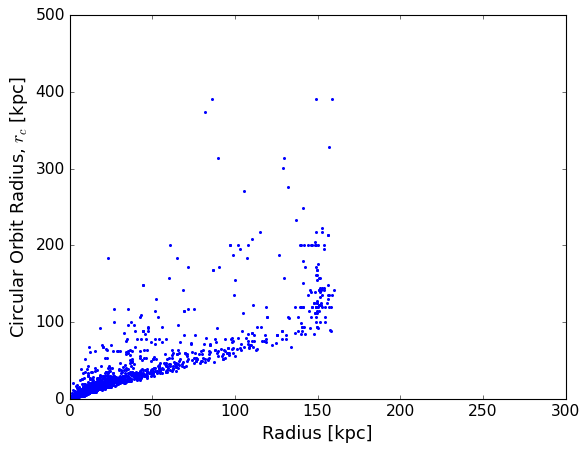

In [27]:
plt.scatter(1e3*r_clus,1e3*rc_clus, s=3, edgecolors='face')
plt.xlabel('Radius [kpc]', fontsize=16)
plt.ylabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.xlim(0,300)
plt.ylim(0,500)

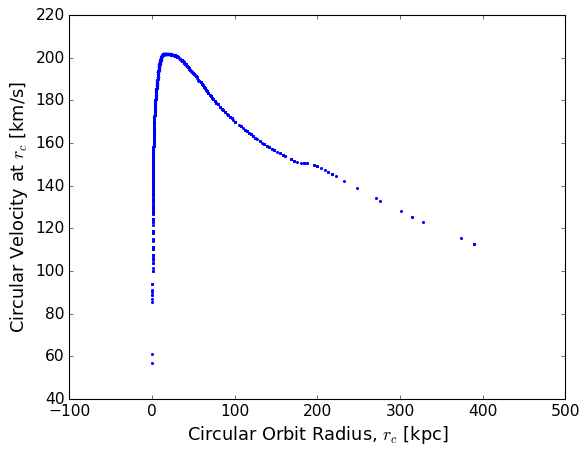

In [28]:
plt.scatter(1e3*rc_clus,vc_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel('Circular Velocity at $r_c$ [km/s]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

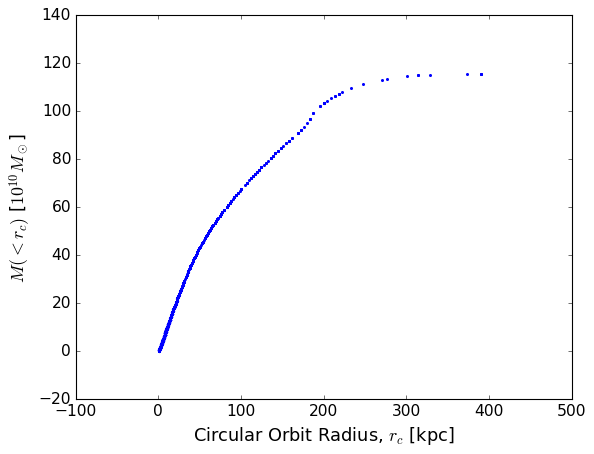

In [29]:
plt.scatter(1e3*rc_clus,M_rc_clus, s=3, edgecolors='face')
plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
plt.ylabel(r'$M(<r_c)$ [$10^{10} M_\odot$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [30]:
# plt.scatter(1e3*rc_clus,sigma_rc_clus, s=3, edgecolors='face')
# plt.xlabel('Circular Orbit Radius, $r_c$ [kpc]', fontsize=16)
# plt.ylabel('Velocity Dispersion [km/s]', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [31]:
Jc_clus = rc_clus*vc_clus
# circ_param_clus0 = np.repeat(Lz[starparts][mask_cluster_final],s.data['nclt'][mask_cluster_final])/Jc_clus
circ_param_clus1 = (np.repeat(J_mod[s.data['type']==4][starparts][mask_cluster_final],s.data['nclt'][starparts][mask_cluster_final])/Jc_clus)

In [32]:
circ_param_clus1.min(), circ_param_clus1.max()

(np.float64(0.027044626959963795), np.float64(1.3936965148710767))

In [33]:
feps = (circ_param_clus1)**0.78
coulumblog = np.log(1. + M_rc_clus/mclus)

In [34]:
# tdf = feps/(2*B(vc_rc_clus/(np.sqrt(2.)*sigma_rc_clus)))*np.sqrt(2.)*sigma_rc_clus*rc_clus**2./(Gcosmo*mclus*coulumblog)
# tdf *= s.UnitLength_in_cm/s.UnitVelocity_in_cm_per_s / (1e9*365.25*24*3600)
# np.nanmin(tdf), np.nanmax(tdf)
clus_age = np.repeat(stars_age[mask_cluster_final],nclus)
clus_age_i = np.repeat(stars_age[mask_cluster_initial],s.data['incl'][starparts][mask_cluster_initial])
# mask_disrupted = (tdf<clus_age)
# mask_disrupted.sum()

In [35]:
# plt.hist(tdf, bins=np.logspace(-1, 3, 20), histtype='step')
# plt.xscale('log')
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Number of Clusters', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [36]:
# cb = plt.scatter(tdf, 1e10*mclus, s=3, c=clus_age, edgecolors='face')
# plt.xscale('log')
# plt.yscale('log')
# cbar = plt.colorbar(cb)
# cbar.set_label('Age [Gyr]', fontsize=16)
# cbar.ax.tick_params(labelsize=14)
# plt.xlabel('Dynamical Friction Timescale [Gyr]', fontsize=16)
# plt.ylabel('Cluster Mass [$M_\odot$]', fontsize=16)
# xticks = plt.xticks()[0]
# plt.xticks(xticks[::2])
# plt.tick_params(axis='both', which='both', labelsize=14)

In [37]:
nbins = 20
min_gcmf = 1e2 # in solar masses
max_gcmf = 1e8 # in solar masses
marray_gcmf = np.linspace(np.log10(min_gcmf), np.log10(max_gcmf), nbins + 1)
width = np.diff(marray_gcmf)

In [38]:
# plt.hist(np.log10(1e10*mclus[mask_disrupted]), bins=marray_gcmf, histtype='step', label='All Clusters', linewidth=3)
# plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
# plt.ylabel(r'$\rm{Disrupted \; Clusters} (\tau < t_{\rm{DF}})$', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [39]:
jz = Lz[s.data['type']==4][starparts]
ii = np.argsort(orbital_energy[s.data['type']==4][starparts])
eps = jz[ii]
npm = 50
eps /= [ np.max(eps[:i+npm]) if i < npm else np.max(eps[i-npm:]) if i > size(ii)-npm else np.max(eps[i-npm:i+npm]) for i in range(size(ii)) ]
ilist = np.array(list(range(0, len(eps))))# ilist=1,2,3,4,5
ilist = ilist[ii] # ilist=5,4,3,2,1
resort = np.argsort(ilist) # resort=5,4,3,2,1
eps = eps[resort] # eps2=5,4,3,2,1

# Build feature array: [ε, Energy]
X = np.vstack((eps,orbital_energy[s.data['type']==4][starparts], np.log10(np.abs(s.data['pos'][:,0][s.data['type']==4][starparts])))).T

# Fit GMM
gmm = GaussianMixture(n_components=2, means_init=[[0.0,np.median(orbital_energy[s.data['type']==4][starparts]), -1.5],
                                                  [0.9,np.median(orbital_energy[s.data['type']==4][starparts]), -2.5]],
                                                  covariance_type='full', random_state=42)
gmm.fit(X)

# Predict cluster memberships
decomp_labels = gmm.predict(X)

In [40]:
median_eps = [np.median(eps[decomp_labels==i]) for i in range(gmm.n_components)]
sph_label = np.argmin(median_eps)
disc_label = np.argmax(median_eps)
print('GMM Label for Spheroid:', sph_label)
print('GMM Label for Disc:', disc_label)

GMM Label for Spheroid: 0
GMM Label for Disc: 1


In [41]:
#Force assign disc_label to clusters with high circularity
mask = (decomp_labels == sph_label) & (eps > 0.7)
decomp_labels[mask] = disc_label

In [42]:
# mask = eps > 0.8
# decomp_labels = mask

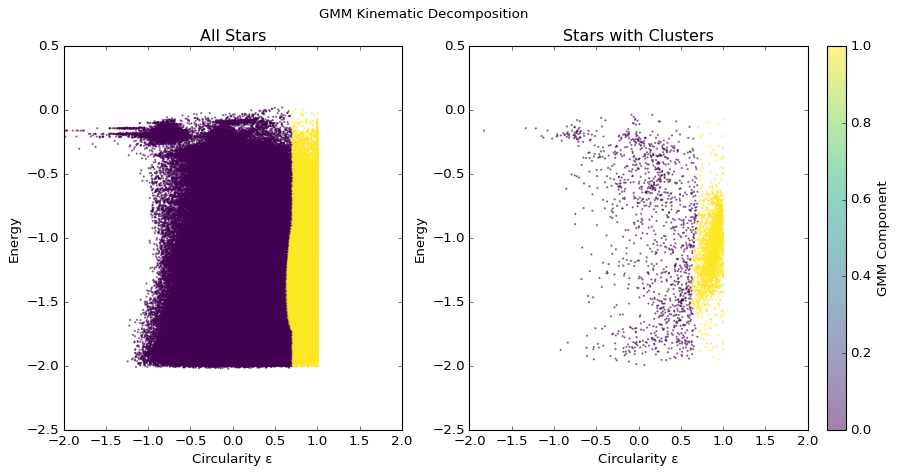

In [43]:
# mask = (s.data['nclt'][(s.data['age']>0)*(parts_radius[starparts]<galrad)]>0)
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].scatter(eps, orbital_energy[s.data['type']==4][starparts], c=decomp_labels, s=1, cmap='viridis', alpha=0.5, edgecolors='face')
cb = ax[1].scatter(eps[mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=decomp_labels[mask_cluster_final], s=1, cmap='viridis', alpha=0.5, edgecolors='face')
for i in range(2):
    ax[i].set_xlabel('Circularity ε')
    ax[i].set_xlim(-2,2)
    ax[i].set_ylabel('Energy')
fig.suptitle('GMM Kinematic Decomposition')
ax[0].set_title('All Stars')
ax[1].set_title('Stars with Clusters')
fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]), label='GMM Component')

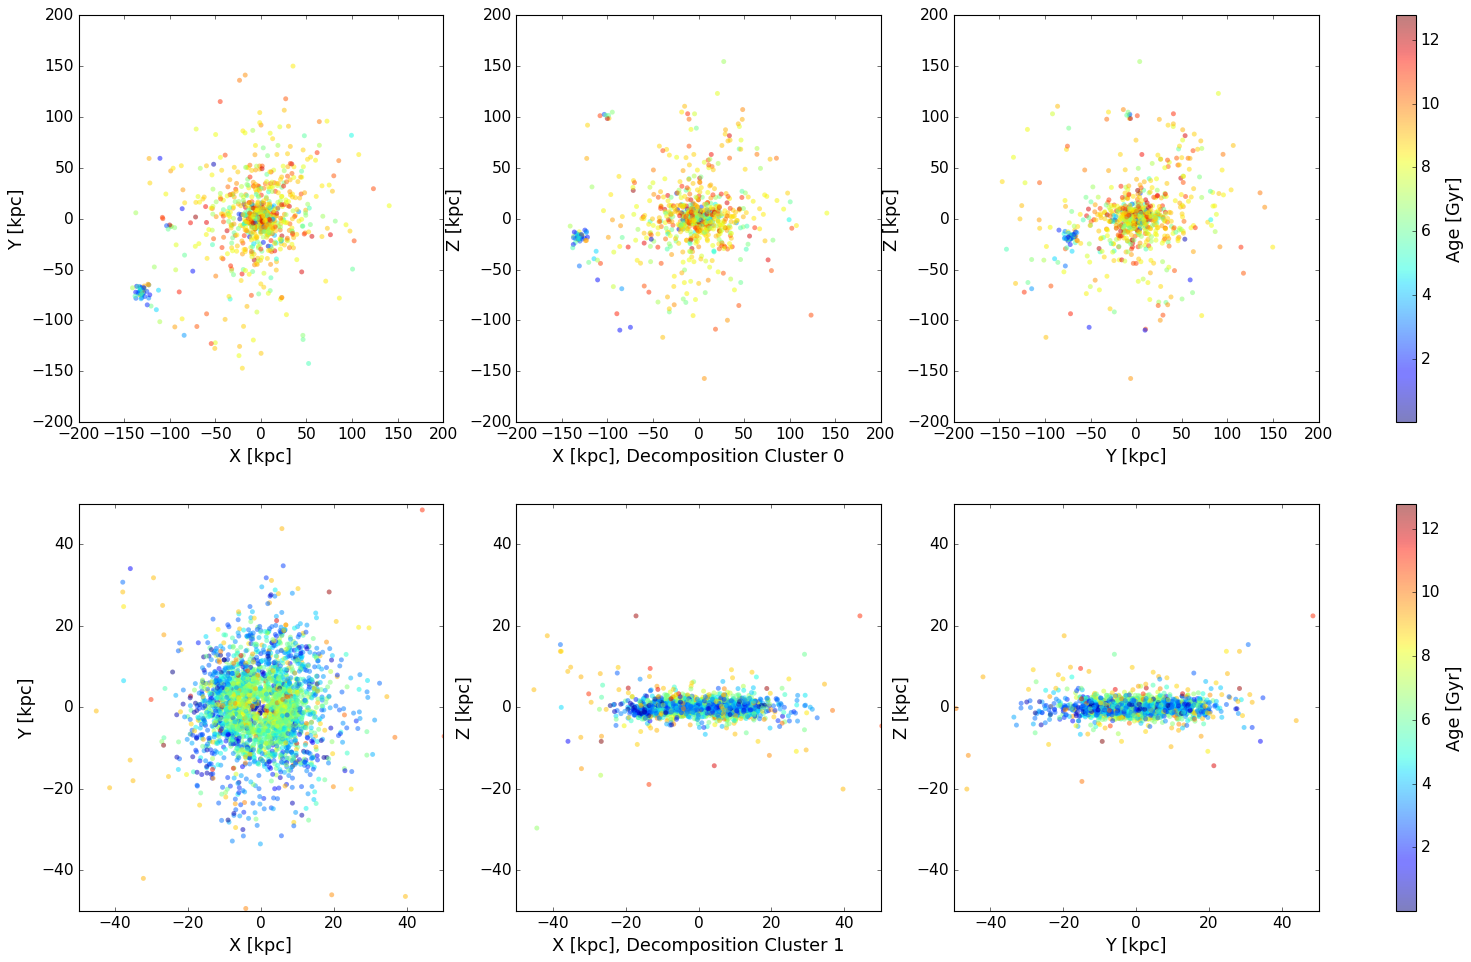

In [44]:
nlabels = gmm.n_components
fig, ax = plt.subplots(nlabels, 3, figsize=(25,7*nlabels))
cbars = []
for i in range(nlabels):
    ax[i,0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,1],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    ax[i,0].set_xlabel('X [kpc]', fontsize=16)
    ax[i,0].set_ylabel('Y [kpc]', fontsize=16)
    ax[i,0].tick_params(axis='both', which='both', labelsize=14)
    ax[i,1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    ax[i,1].set_xlabel('X [kpc], Decomposition Cluster {:1d}'.format(i), fontsize=16)
    ax[i,1].set_ylabel('Z [kpc]', fontsize=16)
    ax[i,1].tick_params(axis='both', which='both', labelsize=14)
    cb = ax[i, 2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==i][:,0],
                    c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==i], alpha=0.5, linewidth=0)
    cbars.append(cb)
    ax[i, 2].set_xlabel('Y [kpc]', fontsize=16)
    ax[i, 2].set_ylabel('Z [kpc]', fontsize=16)
    ax[i, 2].tick_params(axis='both', which='both', labelsize=14)
    if i==sph_label:
        for j in range(3):
            ax[i,j].set(xlim=(-200,200), ylim=(-200,200))
    else:
        for j in range(3):
            ax[i,j].set(xlim=(-50,50), ylim=(-50,50))
# plt.tight_layout()
for i, cbar in enumerate(cbars):
    cbar = fig.colorbar(cb, ax=ax[i].ravel().tolist())
# cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
# cbar = fig.colorbar(cb, ax=ax.ravel().tolist())
    cbar.set_label('Age [Gyr]', fontsize=16)
    cbar.ax.tick_params(labelsize=14)
# plt.savefig('./plots/'+simulation_list[3]+'_position_age_distribution.pdf')

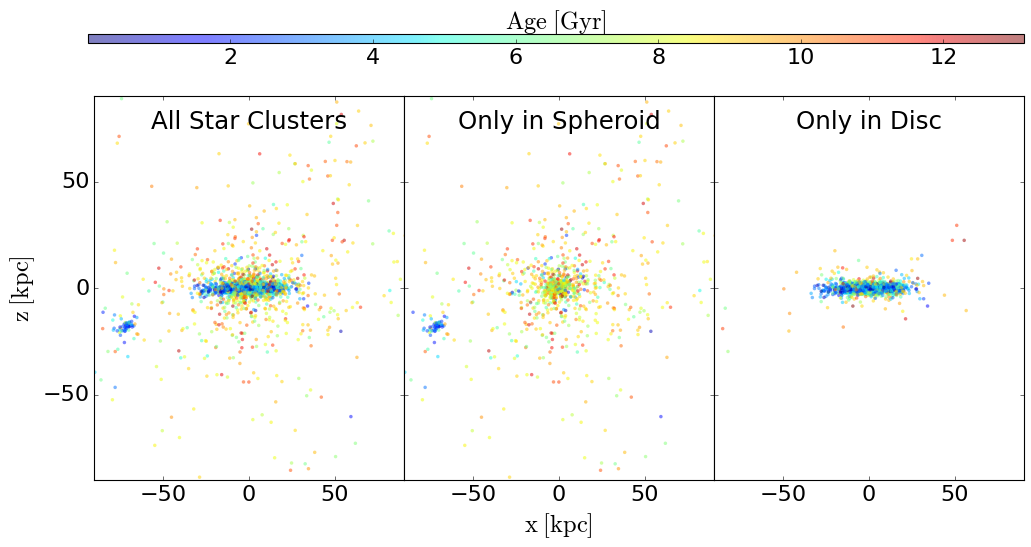

In [45]:
fig, ax = plt.subplots(1, 3, figsize=(15, 6), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.})

cb = ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][:,0],
              c=stars_age[mask_cluster_final], alpha=0.5, linewidth=0, s=10)
ax[0].set_xlim(-90, 90)
ax[0].set_ylim(-90, 90)
ax[0].text(0, 75, 'All Star Clusters', ha='center', fontsize=22)

ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label][:,0],
              c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label], alpha=0.5, linewidth=0, s=10)
ax[1].set_xlim(-90, 90)
ax[1].text(0, 75, 'Only in Spheroid', ha='center', fontsize=22)

ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label][:,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label][:,0],
              c=stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label], alpha=0.5, linewidth=0, s=10)
ax[2].set_xlim(-90, 90)
ax[2].text(0, 75, 'Only in Disc', ha='center', fontsize=22)

ax[0].set_ylabel(r'$\rm{z \; [kpc]}$', fontsize=22)
ax[1].set_xlabel(r'$\rm{x \; [kpc]}$', fontsize=22)
ax[0].tick_params(axis='both', which='both', labelsize=20)
ax[1].tick_params(axis='both', which='both', labelsize=20)
ax[2].tick_params(axis='both', which='both', labelsize=20)

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 1.01, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$\rm{Age} \; [\rm{Gyr}]$', fontsize=22)
cbar.ax.tick_params(labelsize=20)

# cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
# cbar.set_label('Age [Gyr]', fontsize=16)
# cbar.ax.tick_params(labelsize=14)

# plt.savefig('./plots/position_age_distribution_decomp_scbase_paper.pdf', bbox_inches='tight')

In [46]:
mask_old_sph = stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label] > 6.0
mask_old_disc = stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label] > 6.0

print('Fraction of young clusters in spheroid: {:.3f}'.format((~mask_old_sph).sum()/len(stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==sph_label])))
print('Fraction of old clusters in disc: {:.3f}'.format(mask_old_disc.sum()/len(stars_age[mask_cluster_final][decomp_labels[mask_cluster_final]==disc_label])))

Fraction of young clusters in spheroid: 0.274
Fraction of old clusters in disc: 0.491


([], [])

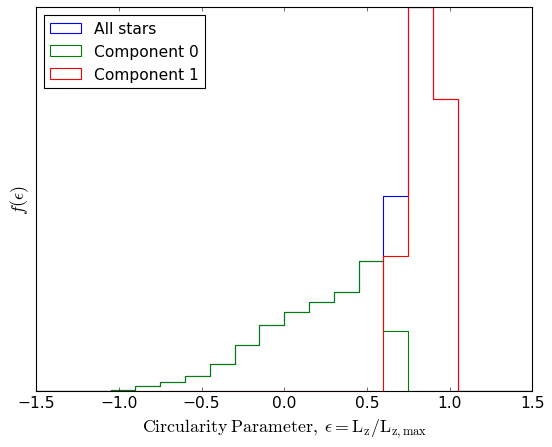

In [47]:
plt.hist(eps, histtype='step', bins=20, range=[-1.5,1.5], label='All stars')
for i in range(gmm.n_components):
    plt.hist(eps[decomp_labels==i], histtype='step', bins=20, range=[-1.5,1.5], label=f'Component {i}')
plt.legend(loc='upper left', fontsize=14)
# plt.vlines(0.8,0,1.4, color='r', linestyles='dashed')
plt.xlabel(r'$\rm{Circularity \; Parameter}, \; \epsilon = L_z/L_{z,\mathrm{max}}$', fontsize=16)
plt.ylabel(r'$f(\epsilon)$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
plt.yticks([])

Text(0, 0.5, '$\\mathrm{d}N \\, / \\, \\mathrm{d} \\log M_{\\mathrm{cl}}$')

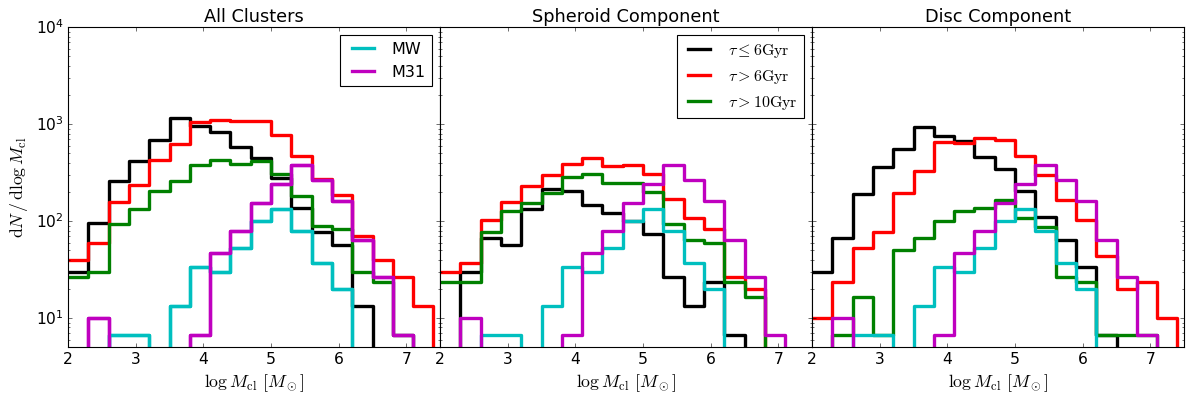

In [48]:
labels = np.repeat(decomp_labels[mask_cluster_final], s.data['nclt'][starparts][mask_cluster_final])
labels_i = np.repeat(decomp_labels[mask_cluster_initial], s.data['incl'][starparts][mask_cluster_initial])

m31_masses = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=11, delimiter=',')
mw_catalogue = np.genfromtxt('catalogues_compare/Harris_onlyphotometry.txt', usecols=(0,6,12), delimiter=',', skip_header=1)
mw_masses = np.log10(1.7 * 10**(0.4*(4.83 - mw_catalogue[:,1])))
N,_ = np.histogram(m31_masses, bins=marray_gcmf)
m31_mass_function = N/width
N,_ = np.histogram(mw_masses, bins=marray_gcmf)
mw_mass_function = N/width

fig, ax = plt.subplots(1,3, figsize=(18,5), sharey=True, gridspec_kw={'hspace': 0.1, 'wspace': 0.})

N,_ = np.histogram(np.log10(1e10*mclus[(clus_age<=6.)]), bins=marray_gcmf)
all_clusters = N/width
# N,_ = np.histogram(np.log10(1e10*mclus), bins=marray_gcmf)
# after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.)]), bins=marray_gcmf)
after_df_old = N/width

ax[0].step(marray_gcmf[:-1], all_clusters, where='post',c='k', linewidth = 3)
# ax[0].step(marray_gcmf[:-1], after_df, where='post',c='b', linewidth = 3)
ax[0].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3)
ax[0].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3)
ax[0].step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c', label='MW')
ax[0].step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m', label='M31')
ax[0].set_title('All Clusters', fontsize=16)

N,_ = np.histogram(np.log10(1e10*mclus[(labels==sph_label) * (clus_age<=6.)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * (labels==sph_label)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.) * (labels==sph_label)]), bins=marray_gcmf)
after_df_old = N/width

ax[1].step(marray_gcmf[:-1], after_df, where='post',c='k', linewidth = 3, label=r'$\tau \leq 6 \rm{Gyr}$')
ax[1].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3, label=r'$\tau > 6 \rm{Gyr}$')
ax[1].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3, label=r'$\tau > 10 \rm{Gyr}$')
ax[1].set_title('Spheroid Component', fontsize=16)

N,_ = np.histogram(np.log10(1e10*mclus[(labels==disc_label) * (clus_age<=6.)]), bins=marray_gcmf)
after_df = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * (labels==disc_label)]), bins=marray_gcmf)
after_df_intermediate = N/width
N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>8.) * (labels==disc_label)]), bins=marray_gcmf)
after_df_old = N/width

ax[2].step(marray_gcmf[:-1], after_df, where='post',c='k', linewidth = 3)
ax[2].step(marray_gcmf[:-1], after_df_intermediate, where='post',c='r', linewidth = 3)
ax[2].step(marray_gcmf[:-1], after_df_old, where='post',c='g', linewidth = 3)
ax[2].set_title('Disc Component', fontsize=16)

for ax_i in ax:
    ax_i.step(marray_gcmf[:-1], mw_mass_function, where='post',linewidth=3, c='c')
    ax_i.step(marray_gcmf[:-1], m31_mass_function, where='post',linewidth=3, c='m')
    ax_i.set_xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
    ax_i.set_xlim(2, 7.5)
    ax_i.tick_params(axis='both', which='both', labelsize=14)
ax[0].legend()
ax[1].legend()
ax[0].set_yscale('log')
ax[0].set_ylim(5e0, 1e4)
ax[0].set_ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)

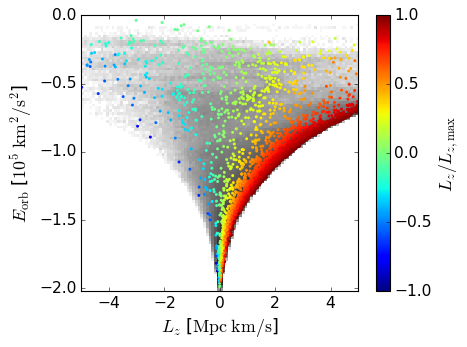

In [49]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
#index, = np.where((s.r() < 0.1) & (s.r() > 0.0))
ax.hist2d( Lz[s.data['type']==4][starparts], orbital_energy[s.data['type']==4][starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[s.data['type']==4][starparts].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter(Lz[s.data['type']==4][starparts][mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=eps[mask_cluster_final], vmin=-1, vmax=1, s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[s.data['type']==4][starparts].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label(r'$L_z / L_{z,\rm{max}}$', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

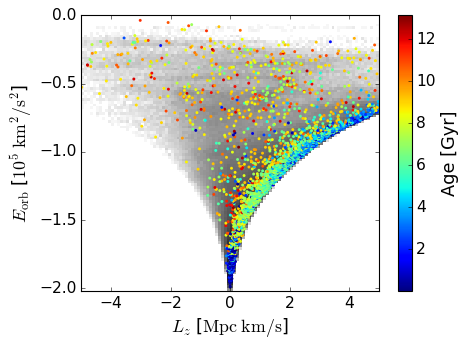

In [50]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.hist2d( Lz[s.data['type']==4][starparts], orbital_energy[s.data['type']==4][starparts], bins=(100, 100), range=([-5, 5], [orbital_energy[s.data['type']==4][starparts].min(), 0.]), rasterized=True, cmap='Greys', norm=mcolors.LogNorm() )
cb = ax.scatter( Lz[s.data['type']==4][starparts][mask_cluster_final], orbital_energy[s.data['type']==4][starparts][mask_cluster_final], c=stars_age[mask_cluster_final], s=7, edgecolors='face', linewidth=0)
ax.set_ylim(orbital_energy[s.data['type']==4][starparts].min(), 0)
cbar = fig.colorbar(cb, ax=ax)
cbar.set_label('Age [Gyr]', fontsize=16)
cbar.ax.tick_params(labelsize=14)
plt.xlabel(r'$L_z$ [$\rm{Mpc} \; \rm{km}/\rm{s}$]', fontsize=16)
plt.ylabel(r'$E_{\rm{orb}}$ [$10^5 \; \rm{km}^2/\rm{s}^2$]', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

In [51]:
# plt.hist(clus_age[~mask_disrupted], bins=20, histtype='step', density=True, label='All Clusters')
# plt.hist(clus_age[(~mask_disrupted) * (labels == 0)], bins=20, histtype='step', density=True, label=r'GCs candidates (Spheroidal)')
# plt.ylim(0, 0.35)
# plt.legend(loc='upper left', fontsize=14)
# plt.xlabel('Cluster`s age [Gyr]', fontsize=16)
# plt.ylabel('Age Distribution', fontsize=16)
# plt.tick_params(axis='both', which='both', labelsize=14)

In [52]:
pressure_units = s.parameters['UnitMass_in_g'] / s.parameters['UnitLength_in_cm'] / (s.parameters['UnitTime_in_s']**2)
density_units = s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**3)
surface_dens_units = s.parameters['UnitMass_in_g'] / (s.parameters['UnitLength_in_cm']**2)

Text(0, 0.5, '$\\log P/k$ [$\\rm{K}/\\rm{cm}^3$]')

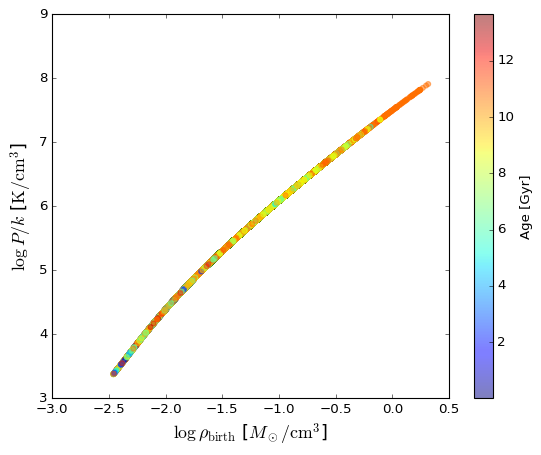

In [53]:
logPoverk = np.repeat(np.log10(s.data['bprs'][starparts][mask_cluster_initial]*pressure_units/k), s.data['nclt'][starparts][mask_cluster_initial])
logPoverk_i = np.repeat(np.log10(s.data['bprs'][starparts][mask_cluster_initial]*pressure_units/k), s.data['incl'][starparts][mask_cluster_initial])
logdens = np.repeat(np.log10(s.data['bdens'][starparts][mask_cluster_initial]*density_units * parsec**3/solar_mass_g), s.data['nclt'][starparts][mask_cluster_initial])
logdens_i = np.repeat(np.log10(s.data['bdens'][starparts][mask_cluster_initial]*density_units * parsec**3/solar_mass_g), s.data['incl'][starparts][mask_cluster_initial])

plt.scatter(logdens_i, logPoverk_i, c=clus_age_i, alpha=0.5, edgecolors='face')
plt.colorbar(label='Age [Gyr]')
plt.xlabel(r'$\log \rho_{\rm{birth}}$ [$M_\odot/\rm{cm}^3$]', fontsize=16)
plt.ylabel(r'$\log P/k$ [$\rm{K}/\rm{cm}^3$]', fontsize=16)

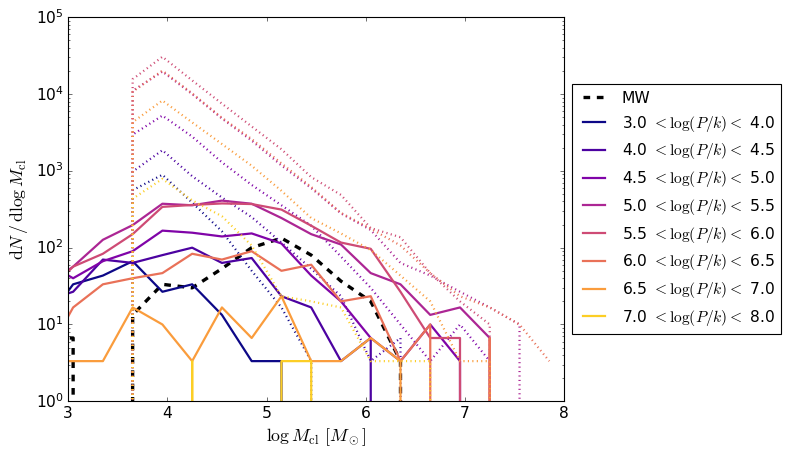

In [54]:
bins_logPoverk = np.concatenate([[3.0],np.arange(4,7.5,0.5),[8.0]])
colors = plt.cm.plasma(np.linspace(0, 0.9, 8))
plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., mw_mass_function, 'k--', linewidth=3, label='MW')
# plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., m31_mass_function, 'k-.', linewidth=3, label='M31')
for i in range(8):
    mask = (logPoverk > bins_logPoverk[i]) & (logPoverk < bins_logPoverk[i+1])
    mask_i = (logPoverk_i > bins_logPoverk[i]) & (logPoverk_i < bins_logPoverk[i+1])
    N,_ = np.histogram(np.log10(1e10*mclus[(clus_age>6.) * mask]), bins=marray_gcmf)
    after_df_intermediate = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., after_df_intermediate, c=colors[i], linewidth = 2, label=f'{bins_logPoverk[i]:.1f} $< \log(P/k) <$ {bins_logPoverk[i+1]:.1f}')
    N,_ = np.histogram(np.log10(imclus[imclus>0][(clus_age_i>6.) * mask_i]), bins=marray_gcmf)
    initial_per_pressbin = N/width
    plt.plot((marray_gcmf[:-1] + marray_gcmf[1:])/2., initial_per_pressbin, c=colors[i], linestyle = 'dotted', linewidth = 2)

plt.yscale('log')
# plt.ylim(5e0, 5e3)
plt.xlim(3, 8)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log M_{\mathrm{cl}}$ $[M_\odot]$', fontsize=16)
plt.ylabel(r'$\mathrm{d}N \, / \, \mathrm{d} \log M_{\mathrm{cl}}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)
# plt.savefig('plots/gcmf_per_birthpressure.pdf',bbox_inches='tight')

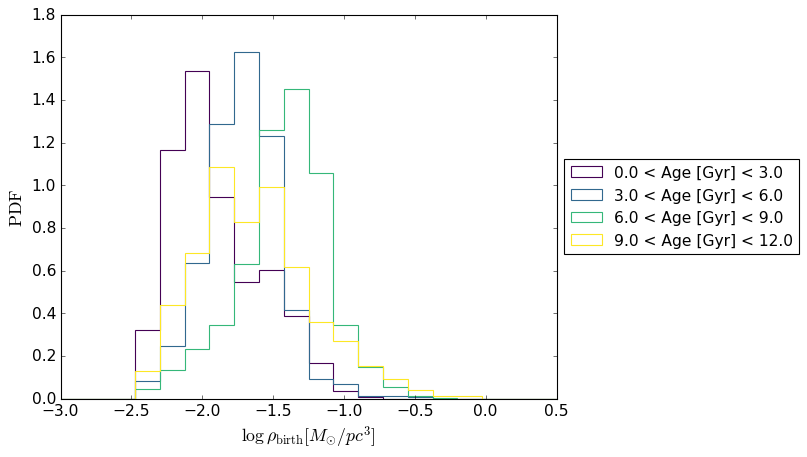

In [55]:
bins_ages = np.arange(0, 15, 3)
colors = plt.cm.viridis(np.linspace(0, 1, 4))
for i in range(len(bins_ages)-1):
    mask = (clus_age > bins_ages[i]) & (clus_age < bins_ages[i+1])
    plt.hist(logdens[mask], bins=20, range=[-3, 0.5], histtype='step', density=True, color=colors[i], label=f'{bins_ages[i]:.1f} < Age [Gyr] < {bins_ages[i+1]:.1f}')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize=14)
plt.xlabel(r'$\log \rho_{\rm{birth}} [M_{\odot}/pc^3]$', fontsize=16)
plt.ylabel(r'$\rm{PDF}$', fontsize=16)
plt.tick_params(axis='both', which='both', labelsize=14)

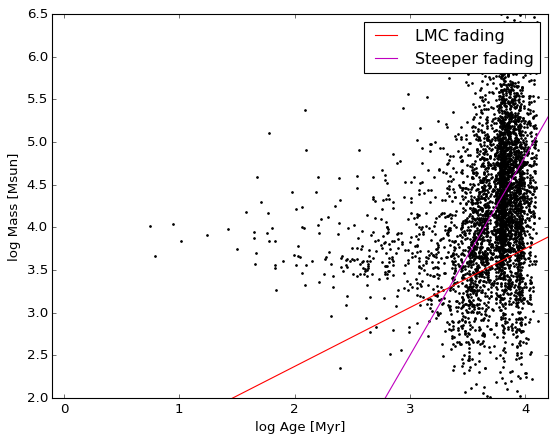

In [56]:
plt.scatter(np.log10(1e3*clus_age), np.log10(1e10*mclus), c='k', s=2)
logage = np.linspace(1, 4.2, 100)
fading1 = 0.69*logage + 0.99
fading2 = 7/3. * logage - 4.5
plt.plot(logage, fading1, c='r', label='LMC fading')
plt.plot(logage, fading2, c='m', label='Steeper fading')
plt.xlim(-.1, 4.2)
plt.ylim(2, 6.5)
plt.xlabel('log Age [Myr]')
plt.ylabel('log Mass [Msun]')
plt.legend()

In [ ]:
def density_scatter( x , y, vmin, vmax, ax = None, sort = True, bins = 20, **kwargs )   :
    """
    Scatter plot colored by 2d histogram
    """
    if ax is None :
        fig , ax = plt.subplots()
    data , x_e, y_e = np.histogram2d( x, y, bins = bins, density=False)
    z = sp.interpolate.interpn( ( 0.5*(x_e[1:] + x_e[:-1]) , 0.5*(y_e[1:]+y_e[:-1]) ) , data , np.vstack([x,y]).T , method = "splinef2d", bounds_error = False)

    #To be sure to plot all data
    z[np.where(np.isnan(z))] = 0.0

    # Sort the points by density, so that the densest points are plotted last
    if sort :
        idx = z.argsort()
        x, y, z = x[idx], y[idx], z[idx]

    h = ax.scatter( x, y, c=z, norm=mcolors.LogNorm(vmin=vmin, vmax=vmax),cmap=cm.viridis, **kwargs )

    return ax, h

In [58]:
min_icmf = 5e3 # in solar masses
max_icmf = 1e8 # in solar masses
marray_icmf = np.linspace(np.log10(min_icmf), np.log10(max_icmf), nbins + 1)

mclus_i = s.data['imcl'][starparts].flatten()
mclus_m = s.data['mclt'][starparts].flatten()
mlsh = s.data['mlsk'][starparts].flatten()
mlrx = s.data['mlrx'][starparts].flatten()
drpt_t = s.data['drpt'][starparts].flatten()
drpt_t = drpt_t[mclus_i>0]
mclus_m = mclus_m[mclus_i>0]*1e10
mlsh = mlsh[mclus_i>0]*1e10
mlrx = mlrx[mclus_i>0]*1e10
mclus_i = mclus_i[mclus_i>0]*1e10

fraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  mask_disrupted = (drpt_t[mask]>0)
  fraction.append(mask_disrupted.sum()/mask.sum())

fraction = np.array(fraction)
fraction = np.nan_to_num(fraction, nan=0.)
drpt_t = s.cosmology_get_lookback_time_from_a(drpt_t, is_flat=True)

massfraction = []
for i in range(nbins):
  mask = (np.log10(mclus_i) > marray_icmf[i]) & (np.log10(mclus_i) < marray_icmf[i+1])
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())

massfraction = np.array(massfraction)
massfraction = np.nan_to_num(massfraction, nan=0.)

/tmp/ipykernel_584495/652925020.py:20: RuntimeWarning: invalid value encountered in scalar divide
  fraction.append(mask_disrupted.sum()/mask.sum())
/tmp/ipykernel_584495/652925020.py:29: RuntimeWarning: invalid value encountered in scalar divide
  massfraction.append(mclus_m[mask].sum()/mclus_i[mask].sum())


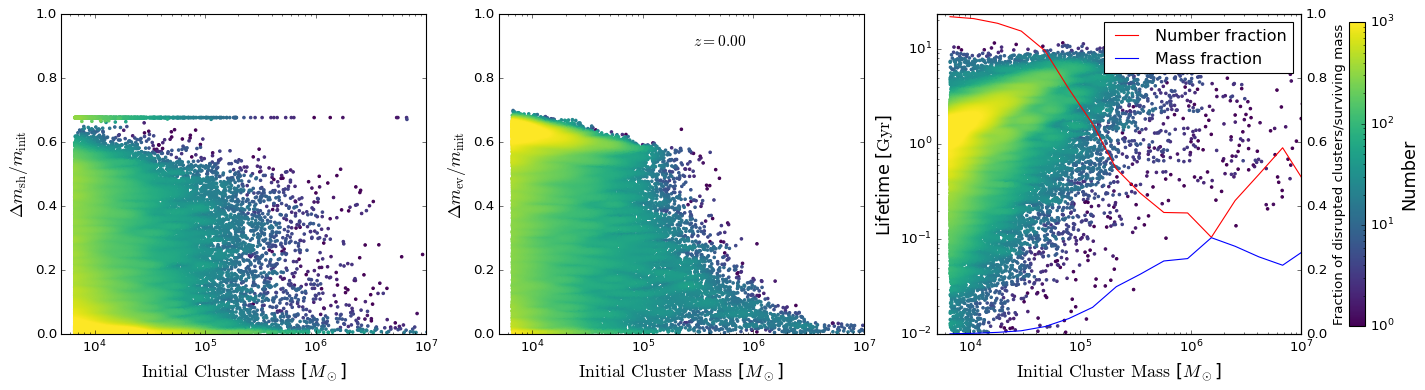

In [59]:
fig, ax = plt.subplots(1, 3, figsize=(20,5))
ax[0], cb1 = density_scatter(mclus_i, mlsh/mclus_i, vmin=1e0, vmax=1e3, ax=ax[0],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[0].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[0].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[0].set_ylabel(r'$\Delta m_{\rm{sh}}/m_{\rm{init}}$', fontsize=16)
ax[0].tick_params(labelsize=12)

ax[1], cb1 = density_scatter(mclus_i, mlrx/mclus_i, vmin=1e0, vmax=1e3, ax=ax[1],bins=[10**marray_icmf, np.linspace(0,1.1,100)], edgecolors='face', s=5)
ax[1].text(5e5, 0.9, r'$z={:.2f}$'.format(s.redshift), fontsize=14, ha='center')
ax[1].set(xscale='log', xlim=(5e3, 1e7), ylim=(0,1))
ax[1].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[1].set_ylabel(r'$\Delta m_{\rm{ev}}/m_{\rm{init}}$', fontsize=16)
ax[1].tick_params(labelsize=12)

ax[2], cb = density_scatter(mclus_i, np.repeat(stars_age,s.data['incl'][starparts]) - drpt_t, vmin=1e0, vmax=1e3, ax=ax[2], bins=[10**marray_icmf, np.logspace(-2,1.5,100)], edgecolors='face', s=5)
ax[2].set(xscale='log', yscale='log', xlim=(5e3, 1e7), ylim=(1e-2, 2.3e1))
ax[2].set_xlabel(r'$\rm{Initial}$ $\rm{Cluster}$ $\rm{Mass}$ [$M_\odot$]', fontsize=16)
ax[2].set_ylabel(r'Lifetime [$\rm{Gyr}$]', fontsize=16)
ax[2].tick_params(labelsize=12)
ax2 = ax[2].twinx()
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, fraction, color='r', label='Number fraction')
ax2.plot((10**marray_icmf[:-1] + 10**marray_icmf[1:])/2, massfraction, color='b', label='Mass fraction')
ax2.set_ylim(0, 1)
ax2.set_ylabel('Fraction of disrupted clusters/surviving mass')
ax2.legend()
cbar_ax = fig.add_axes([.93, 0.12, 0.01, 0.76])
cbar = fig.colorbar(cb, cax=cbar_ax)
cbar.set_label('Number', size=16)

In [60]:
element = {'H':0, 'He':1, 'C':2, 'N':3, 'O':4, 'Ne':5, 'Mg':6, 'Si':7, 'Fe':8}
elementnum = {'H':1, 'He':4, 'C':12, 'N':14, 'O':16, 'Ne':20, 'Mg':24, 'Si':28, 'Fe':56}
#from Asplund et al. (2009) Table 5
SUNABUNDANCES = {'H':12.0, 'He':10.98, 'C':8.47, 'N':7.87, 'O':8.73, 'Ne':7.97, 'Mg':7.64, 'Si':7.55, 'Fe':7.54}
for iel,val in enumerate(element):
    s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
    s.data[val+'/H'] -= (SUNABUNDANCES[val] - SUNABUNDANCES['H'])

s.data['Z/H'] = np.log10(s.data['gz']/0.0127)

/tmp/ipykernel_584495/1632773268.py:6: RuntimeWarning: divide by zero encountered in log10
  s.data[val+'/H'] = np.log10( s.data['gmet'][:, element[val]] / s.data['gmet'][:, element['H']] / elementnum[val] )
/tmp/ipykernel_584495/1632773268.py:9: RuntimeWarning: divide by zero encountered in log10
  s.data['Z/H'] = np.log10(s.data['gz']/0.0127)


In [61]:
m31_metallicity = np.genfromtxt('catalogues_compare/Caldwell_dataonly.txt', usecols=8, delimiter=',')
mw_metallicity = mw_catalogue[:,0]

maskbaryons = s.data['type'][(s.data['type'] == 4) | (s.data['type'] == 0)] == 4
feh_scs = np.repeat(s.data['Fe/H'][maskbaryons][starparts], s.data['nclt'][starparts])
feh_scs_i = np.repeat(s.data['Fe/H'][maskbaryons][starparts], s.data['incl'][starparts])
zh_scs = np.repeat(s.data['Z/H'][maskbaryons][starparts], s.data['nclt'][starparts])
zh_scs_i = np.repeat(s.data['Z/H'][maskbaryons][starparts], s.data['incl'][starparts])

gc_cand_i = (mclus_i > 1e5) * (labels_i == sph_label)
gc_cand_6 = (mclus_i[mclus_m>0] > 1e5) * (labels == sph_label) *(clus_age > 6.)
gc_cand_10 = (mclus_i[mclus_m>0] > 1e5) * (labels == sph_label) *(clus_age > 10.)

Text(0, 0.5, '$\\rm{d}N_{\\rm{GC}} \\, / \\, \\rm{d} [\\rm{Fe/H}]$')

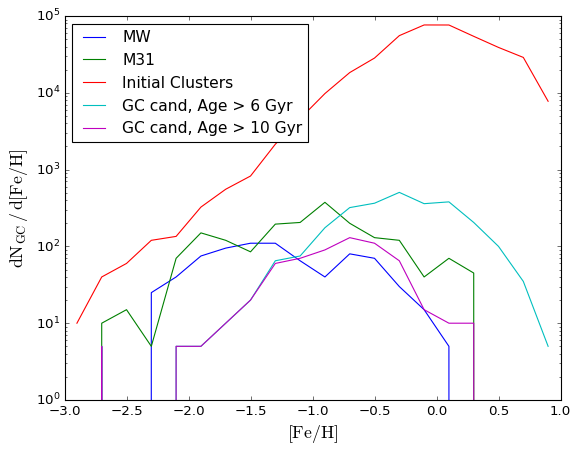

In [62]:
N, binw = np.histogram(mw_metallicity, bins=20, range=[-3,1])
width = np.diff(binw)
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='MW')
N, binw = np.histogram(m31_metallicity, bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='M31')
N,binw = np.histogram(feh_scs_i, bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='Initial Clusters')
N,binw = np.histogram(feh_scs[gc_cand_6], bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='GC cand, Age > 6 Gyr')
N,binw = np.histogram(feh_scs[gc_cand_10], bins=20, range=[-3,1])
plt.plot((binw[1:]+binw[:-1])/2., N/width, label='GC cand, Age > 10 Gyr')
plt.yscale('log')
plt.legend(loc='upper left', fontsize=14)
plt.xlabel(r'$\rm{[Fe/H]}$', fontsize=16)
plt.ylabel(r'$\rm{d}N_{\rm{GC}} \, / \, \rm{d} [\rm{Fe/H}]$', fontsize=16)

In [63]:
TT_gas = s.data['ttij'][s.data['type']==0][s.data['sfr']>0] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_g = np.isfinite(TT_gas).all(axis=1)
TT_gas = TT_gas[finite_mask_g]
TT_star = s.data['ttij'][s.data['type']==4][starparts][(stars_age<0.05)] / s.parameters['UnitTime_in_s']**2 * gyr**2
finite_mask_s = np.isfinite(TT_star).all(axis=1)
TT_star = TT_star[finite_mask_s]

TT_gas_lambda = np.linalg.eigvalsh(TT_gas.reshape(len(TT_gas),3,3))
TT_gas_lambda = np.sort(TT_gas_lambda, axis=1)
TT_star_lambda = np.linalg.eigvalsh(TT_star.reshape(len(TT_star),3,3))
TT_star_lambda = np.sort(TT_star_lambda, axis=1)

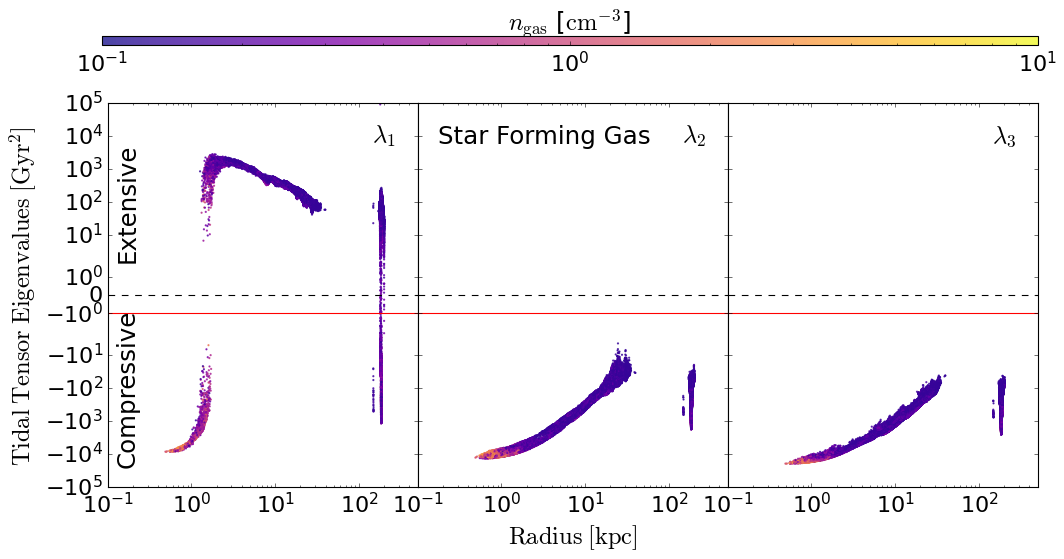

In [64]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(15,6))

for idx, axes in enumerate(ax):
    cb = axes.scatter(s.r()[s.data['type']==0][s.data['sfr']>0][finite_mask_g]*1e3, TT_gas_lambda[:,-1-idx], c=s.data['rho'][s.data['sfr']>0][finite_mask_g] *density_units / 1.6726e-24, edgecolors='face',\
                      s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-1e5, 1e5), xscale='log', xlim=(1e-1, 5e2))
    # axes.set(yscale='symlog', xscale='log')
    axes.tick_params(axis='both', which='both', labelsize=20)

ax[0].text(1.75e-1, 1e2, 'Extensive', fontsize=22, color='k', rotation=90, ha='center', va='center')
ax[0].text(1.75e-1, -1e2, 'Compressive', fontsize=22, color='k', rotation=90, ha='center', va='center')

ax[0].text(2e2, 1e4, r'$\lambda_1$', fontsize=22, color='k', rotation=0, ha='center', va='center')
ax[1].text(2e2, 1e4, r'$\lambda_2$', fontsize=22, color='k', rotation=0, ha='center', va='center')
ax[2].text(2e2, 1e4, r'$\lambda_3$', fontsize=22, color='k', rotation=0, ha='center', va='center')

ax[1].text(1.75e-1, 1e4, 'Star Forming Gas', fontsize=22, color='k', ha='left', va='center')

ax[0].set_ylabel(r'$\rm{Tidal\; Tensor\; Eigenvalues\; [Gyr^2]}$', fontsize=22)
ax[1].set_xlabel(r'$\rm{Radius\; [kpc]}$', fontsize=22)

cbar = fig.colorbar(cb, cax=fig.add_axes([0.12, 1.02, 0.78, 0.02]), orientation='horizontal')
cbar.ax.set_title(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=22)
cbar.ax.tick_params(labelsize=20)
# cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
# cbar.set_label(r'$n_{\rm{gas}}$ [$\rm{cm}^{-3}$]', fontsize=22)

plt.subplots_adjust(wspace=0.0)
# plt.savefig('./plots/TTgas_eigenvalues_paper.pdf', bbox_inches='tight')

/tmp/ipykernel_584495/1367119359.py:13: UserWarning: Adding colorbar to a different Figure <Figure size 1200x480 with 4 Axes> than <Figure size 1440x400 with 4 Axes> which fig.colorbar is called on.
  cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))


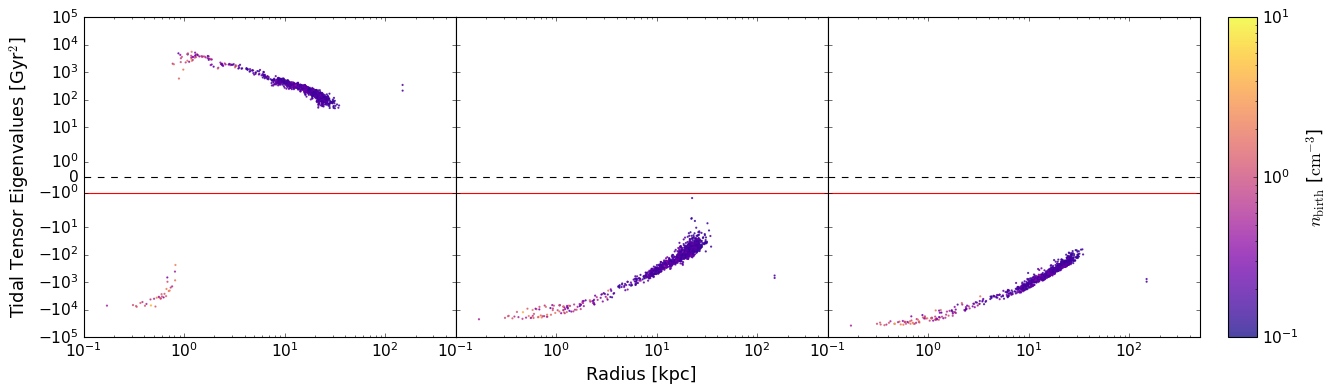

In [65]:
fig, ax = plt.subplots(1, 3, sharey=True, figsize=(18,5))

for idx, axes in enumerate(ax):
    axes.scatter(s.r()[s.data['type']==4][starparts][stars_age<0.05][finite_mask_s]*1e3, TT_star_lambda[:,-1-idx], c=s.data['bdens'][starparts][stars_age<0.05][finite_mask_s]*density_units/1.6726e-24,\
                  edgecolors='face', s=1, alpha=0.75, norm=mcolors.LogNorm(vmin=1e-1, vmax=1e1), cmap='plasma')
    axes.hlines(0, 1e-1, 5e2, color='k', linestyles='dashed')
    axes.hlines(-1e0, 1e-1, 5e2, color='r')
    axes.set(yscale='symlog', ylim=(-1e5, 1e5), xscale='log', xlim=(1e-1, 5e2))
    axes.tick_params(axis='both', which='both', labelsize=14)

ax[0].set_ylabel(r'Tidal Tensor Eigenvalues [Gyr$^2$]', fontsize=16)
ax[1].set_xlabel('Radius [kpc]', fontsize=16)
cbar = fig.colorbar(cb, cax=fig.add_axes([0.92, 0.1, 0.02, 0.8]))
cbar.set_label(r'$n_{\rm{birth}}$ [$\rm{cm}^{-3}$]', fontsize=16)
cbar.ax.tick_params(labelsize=14)

plt.subplots_adjust(wspace=0.0)

Text(0, 0.5, '$\\Gamma$')

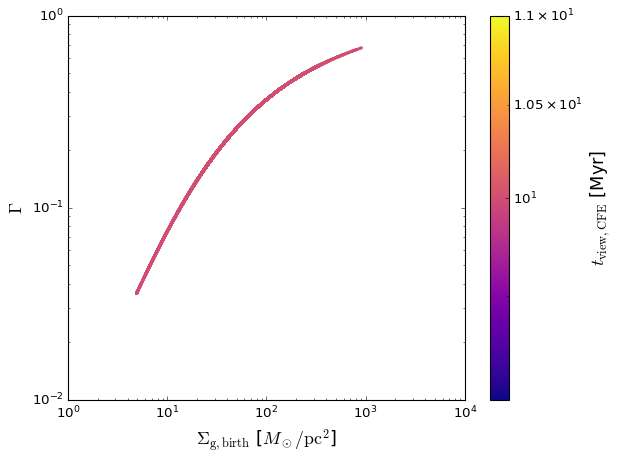

In [66]:
plt.scatter(s.data['bsig'][starparts][mask_cluster_initial] * surface_dens_units * parsec**2/solar_mass_g, s.data['lcfe'][starparts][mask_cluster_initial], \
            c=s.data['tcfe'][starparts][mask_cluster_initial]/3.15576e13, edgecolors='face', norm=mcolors.LogNorm(), cmap='plasma', s=3)
cb = plt.colorbar()
cb.set_label(label=r'$t_{\rm{view, CFE}}$ [Myr]', fontsize=16)
plt.xscale('log')
plt.yscale('log')
plt.xlabel(r'$\Sigma_{\rm{g, birth}}$ [$M_\odot/\rm{pc}^2$]', fontsize=16)
plt.ylabel(r'$\Gamma$', fontsize=16)

Disrupted GCs: 1636  of  2263


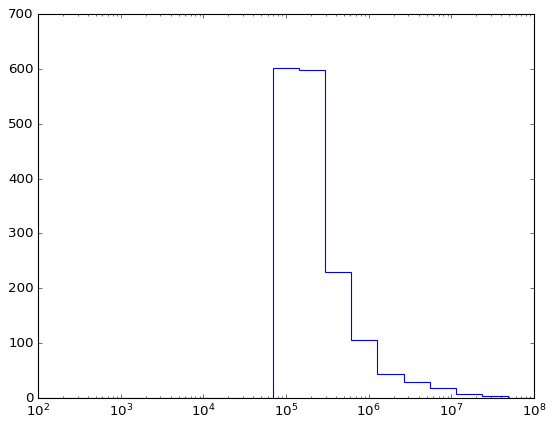

In [67]:
labels_i = np.repeat(decomp_labels, s.data['incl'][starparts])
print('Disrupted GCs:', np.sum((mclus_i>1e5) * (labels_i==sph_label) * (mclus_m < 1e2)), ' of ', np.sum((mclus_i>1e5) * (labels_i==sph_label)))

plt.hist(mclus_i[(mclus_i>1e5) * (labels_i==sph_label) * (mclus_m < 1e2)], bins=np.logspace(2, 8, 20), histtype='step', label='GCs')
plt.xscale('log')

In [68]:
halomass_gcmass_rel = np.array([
    [13.776978417266186, 9.413743767393687],
    [13.805755395683452, 9.367260995849572],
    [13.18705035971223, 9.295890848039624],
    [13.136690647482014, 9.27480697596094],
    [13.363309352517987, 9.059230334845111],
    [13.20863309352518, 8.848145981630745],
    [13.046762589928054, 8.590604179802936],
    [13.49640287769784, 9.380150367562338],
    [13.478417266187048, 9.447744866408879],
    [13.014388489208633, 9.232654425561979],
    [12.85611510791367, 8.877961200205622],
    [12.575539568345324, 8.751442773975118],
    [12.485611510791369, 8.713491297774873],
    [12.39568345323741, 8.793808036991736],
    [12.43525179856115, 8.295364131081618],
    [12.33093525179856, 8.274318243398945],
    [12.280575539568343, 8.257458236156586],
    [12.284172661870503, 8.181426136809664],
    [12.388489208633095, 8.202472024492337],
    [12.431654676258994, 8.109516610576375],
    [12.417266187050359, 8.029273307858464],
    [12.449640287769785, 7.851848194095199],
    [12.197841726618705, 8.18148691184328],
    [11.938848920863308, 8.059177156690698],
    [12.097122302158272, 7.957692979723929],
    [12.187050359712229, 7.932286483379293],
    [12.183453237410072, 7.864707178291159],
    [12.284172661870503, 7.847740814739971],
    [12.26978417266187, 7.919556646129769],
    [11.877697841726619, 8.05077247600019],
    [11.467625899280575, 8.14821004864535],
    [11.77697841726619, 7.979037677988549],
    [11.737410071942445, 7.936826884849037],
    [11.971223021582734, 7.949333880308634],
    [11.895683453237407, 7.907148410099798],
    [11.93884892086331, 7.877550968728713],
    [11.924460431654675, 7.7423974231385735],
    [11.96402877697842, 7.679011595369954],
    [12.129496402877699, 7.518388246108499],
    [11.94964028776978, 7.510067131089214],
    [11.838129496402876, 7.366534227739243],
    [11.676258992805757, 7.611632341434138],
    [11.514388489208635, 7.603298564949517],
    [11.327338129496402, 7.594982514516369],
    [11.298561151079138, 7.540092529988679],
    [11.557553956834532, 7.42586585430705],
    [11.597122302158272, 7.341360702356805],
    [11.651079136690647, 7.307531799270192],
    [11.708633093525176, 7.062507122074251],
    [11.535971223021583, 7.2358071304308185],
    [11.586330935251798, 7.235771678327875],
    [11.377697841726619, 7.38797768543349],
    [11.363309352517986, 7.265495734352326],
    [11.406474820143885, 7.10495848305516],
    [11.564748201438848, 6.9189970093618856],
    [11.255395683453234, 7.257123973471696],
    [11.269784172661872, 7.197979736590875],
    [11.309352517985612, 7.151489368167556],
    [10.985611510791367, 7.384029840541504],
    [11.097122302158274, 7.130519449276902],
    [11.215827338129497, 6.754511913172734],
    [11.021582733812949, 6.805335035034274],
    [10.946043165467625, 6.9743428066416975],
    [10.953237410071942, 7.151740065181222],
    [10.888489208633093, 7.189800429983361],
    [10.877697841726619, 7.371434214824549],
    [10.625899280575538, 7.4011785291935395],
    [10.71223021582734, 7.088551756271855],
    [10.70863309352518, 7.016748586347395],
    [10.766187050359711, 6.982917150967715],
    [10.81294964028777, 7.058913798211694],
    [10.776978417266188, 7.033595932124415],
    [10.888489208633093, 7.088427673911557],
    [10.967625899280575, 6.796925289757633],
    [10.96043165467626, 6.74202011147154],
    [10.74820143884892, 6.7844081651257655],
    [10.89208633093525, 6.573113631586811],
    [10.888489208633093, 6.484415002317047],
    [10.737410071942445, 6.573222520188708],
    [10.726618705035971, 6.530991468704656],
    [10.586330935251798, 6.7253880106052435],
    [10.568345323741006, 6.949265508395817],
    [10.338129496402878, 6.755129792681165],
    [10.568345323741008, 6.315685782947032],
    [10.672661870503596, 6.3282839409570535],
    [10.633093525179856, 6.3240879313444704],
    [10.64748201438849, 6.345197126353826],
    [10.701438848920862, 6.205771602359084],
    [10.780575539568346, 6.18037270289365],
    [10.798561151079138, 6.2057032304462645],
    [10.823741007194245, 6.231028693412744],
    [10.478417266187051, 6.032750146239924],
    [10.586330935251798, 7.063297197511261],
    [11.381294964028775, 6.606560158420253],
    [11.151079136690646, 6.518021063613734],
    [11.888489208633093, 6.973679345858054],
    [9.68705035971223, 6.907647271834064],
    [10.140287769784173, 6.789059987490472],
    [10.49640287769784, 6.488914887097712],
    [10.57553956834532, 6.54376941952246],
    [10.507194244604321, 6.227027670366346],
    [10.442446043165466, 6.155267549424028],
    [10.456834532374101, 6.096123312543207],
    [10.661870503597122, 6.036844864129814],
    [10.85251798561151, 6.1127402196511],
    [10.633093525179856, 5.834119610330742],
    [10.654676258992804, 5.614463445083426],
    [10.568345323741008, 5.504703734372585],
    [10.467625899280577, 5.504774638578471],
    [10.028776978417266, 6.138663303781472],
    [9.827338129496404, 6.143028977029568],
    [8.787769784172662, 6.384521105396568],
    [8.866906474820144, 6.046556208043068],
    [9.26978417266187, 6.113854428600729],
    [9.06115107913669, 5.864793276255446],
    [9.586330935251798, 5.881319020812916],
    [9.892086330935252, 5.834641262702613],
    [9.874100719424458, 5.724833438423495],
    [10.06474820143885, 5.606431011473819],
    [10.007194244604317, 5.471307853400488],
    [9.942446043165464, 5.699442135837264],
    [9.672661870503596, 5.657393409454062],
    [9.471223021582734, 5.42944651670427],
    [10.31654676258993, 5.24722523987146],
    [10.420863309352516, 4.537542510869866],
    [9.902877697841724, 4.352057108273255],
    [9.48201438848921, 4.601561411905322],
    [8.496402877697841, 5.058432662528898],
    [7.769784172661871, 4.763273647185735],
    [7.992805755395683, 4.31538697236509],
    [7.111510791366907, 4.176619844567851],
    [8.158273381294965, 4.032271542850199],
    [8.442446043165468, 4.1207726532607065],
    [8.816546762589928, 4.1627479431449546],
    [9.053956834532373, 3.596582923734929],
    [9.276978417266188, 3.558411138037825],
    [10.007194244604317, 3.0890480857130544],
    [9.85251798561151, 3.0891569743149496],
    [9.784172661870503, 3.093428952719557],
    [9.694244604316548, 3.0934922600462365],
    [9.661870503597122, 3.0935150506838465],
    [9.640287769784173, 3.0935302444422472],
    [9.600719424460433, 3.093558099665988],
    [9.464028776978417, 3.0894304619662227],
    [9.29496402877698, 3.0895494797403877],
    [9.230215827338128, 3.081147331342949],
    [9.20863309352518, 3.0811625251013552],
    [9.179856115107913, 3.081182783445894],
    [9.161870503597122, 3.0811954449112307],
    [9.140287769784173, 3.081210638669633],
    [9.118705035971223, 3.0812258324280366],
    [9.10431654676259, 3.0812359616003064],
    [9.082733812949641, 3.08125115535871],
    [9.06474820143885, 3.0812638168240465],
    [7.2769784172661875, 3.08674623131484],
    [7.345323741007195, 3.090921982582887],
    [7.510791366906475, 3.0908054971017904],
    [7.550359712230216, 3.0907776418780504],
    [7.597122302158273, 3.0907447220681714],
    [7.7805755395683445, 3.0906155751217383],
    [7.816546762589928, 3.090590252191065],
    [7.928057553956835, 3.0905117511059794],
    [8.03956834532374, 3.086209385184567],
    [8.06115107913669, 3.0861941914261584],
    [8.093525179856115, 3.0861714007885555],
    [8.111510791366907, 3.086158739323217],
    [8.226618705035971, 3.086077705945062],
    [8.31654676258993, 3.077566668945728],
    [8.392086330935252, 3.077513490791315],
    [8.417266187050359, 3.0774957647398438],
    [8.442446043165466, 3.0774780386883718],
    [8.482014388489208, 3.0816740483009557],
    [8.525179856115107, 3.081643660784146],
    [8.57913669064748, 3.0816056763881345],
    [8.690647482014388, 3.0815271753030506],
    [8.762589928057555, 3.0814765294417032],
    [8.787769784172662, 3.081458803390232],
    [8.809352517985612, 3.081443609631827],
    [8.83453237410072, 3.077202018744032],
    [8.856115107913668, 3.0771868249856276],
    [8.877697841726619, 3.077171631227224],
    [8.902877697841726, 3.081377770012077]])

In [69]:
halobins = np.linspace(6.5, 14.5, 10)
halomass_gcmass_rel[halomass_gcmass_rel<3.5]=0.0
median_relation = []
sigma_low_relation = []
sigma_high_relation = []
for i in range(len(halobins)-1):
    mask = (halomass_gcmass_rel[:,0] > halobins[i]) & (halomass_gcmass_rel[:,0] < halobins[i+1])
    median_relation.append(np.median(halomass_gcmass_rel[mask,1]))
    sigma_low_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 2.3))
    sigma_high_relation.append(np.percentile(halomass_gcmass_rel[mask,1], 97.7))

median_relation = np.array(median_relation)
sigma_low_relation = np.array(sigma_low_relation)
sigma_high_relation = np.array(sigma_high_relation)

In [70]:
np.log10(sf.data['fmm2'][0]*1e10)

np.float32(12.110821)

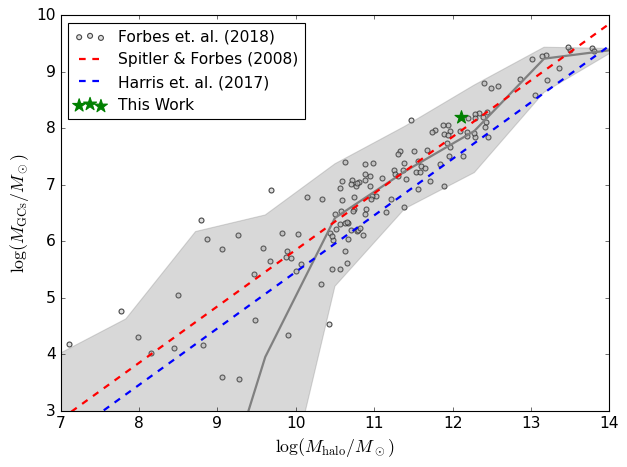

In [71]:
plt.scatter(halomass_gcmass_rel[:,0], halomass_gcmass_rel[:,1], c='lightgrey', label='Forbes et. al. (2018)', alpha=0.7)
plt.plot((halobins[1:]+halobins[:-1])/2., median_relation, color='grey', linewidth=2)
plt.fill_between((halobins[1:]+halobins[:-1])/2., sigma_low_relation, sigma_high_relation, color='grey', alpha=0.3)
logmhalo = np.linspace(7, 14, 100)
plt.plot(logmhalo, logmhalo - 4.15, color='r', linewidth=2, linestyle='dashed', label='Spitler & Forbes (2008)')
plt.plot(logmhalo, logmhalo - 4.54, color='b', linewidth=2, linestyle='dashed', label='Harris et. al. (2017)')
plt.scatter(np.log10(sf.data['fmm2'][0]*1e10), np.log10(mclus_m[(mclus_i>1e5) * (labels_i==sph_label) * (clus_age_i>6.)].sum()), marker='*', color='g', s=150, label='This Work')
plt.xlim(7, 14)
plt.ylim(3, 10)
plt.xlabel(r'$\log(M_{\rm{halo}}/M_\odot)$', fontsize=16)
plt.ylabel(r'$\log(M_{\rm{GCs}}/M_\odot)$', fontsize=16)
plt.legend(loc='upper left', fontsize=14)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('./plots/halomass_gcmass_relation_paper.pdf', bbox_inches='tight')

In [72]:
treepath = path+simulation_list[sim_id]+'/trees/'
t = load_tree(0, 0, base=treepath+'trees_sf1_%03d' % snap_id, verbose=False)
"""Some of the quantities are automatically transformed at this step"""

TypeError: %d format: a real number is required, not builtin_function_or_method

In [ ]:
mergers_z = []
idx = 0
while idx != -1:
    npin = t.data['npin'][idx]
    major_mergers = 0
    main_mass = t.data['smty'][idx, 4].sum()
    while npin != -1:
        next_mass = t.data['smty'][npin, 4].sum()
        if next_mass>0 and main_mass>0:
            ratio = next_mass/main_mass
            if ratio>1./4.:
                major_mergers += 1
        npin = t.data['npin'][npin]
    if major_mergers > 0:
        # print(f"Subhalo {t.data['sbnr'][idx]} in snapshot {snap} merged with {merged} luminous subhalos")
        print(f"Major merger at {t.data['reds'][idx]}")
        mergers_z.append(t.data['reds'][idx])
    idx = t.data['fpin'][idx]

Major merger at 2.20792555809021


In [ ]:
snap_numbers_main,redshifts_main,subfind_indices_main,first_progs_indices_main,ff_tree_indices_main,fof_indices_main,prog_mass_main,next_prog_indices = t.return_first_next_mass_progenitors(0)
print('snap_numbers_main,redshifts_main=',snap_numbers_main,redshifts_main)
print('subfind_indices_main,fof_indices_main=',subfind_indices_main,fof_indices_main)

snap_numbers_main,redshifts_main= [127 126 125 124 123 122 121 120 119 118 117 116 115 114 113 112 111 110
 109 108 107 106 105 104 103 102 101 100  99  98  97  96  95  94  93  92
  91  90  89  88  87  86  85  84  83  82  81  80  79  78  77  76  75  74
  73  72  71  70  69  68  67  66  65  64  63  62  61  60  59  58  57  56
  55  54  53  52  51  50  49  48  47  46  45  44  43  42  41  40  39  38
  37  36  35  34  33  32  31  30  29  28  27  26  25  24  23  22  21  20
  19  18] [2.22044605e-16 9.52166691e-03 2.39744280e-02 3.37243713e-02
 4.85236309e-02 5.85073233e-02 7.36613870e-02 8.38844329e-02
 9.94018018e-02 1.09869942e-01 1.25759333e-01 1.41876206e-01
 1.52748764e-01 1.69252038e-01 1.80385262e-01 1.97284177e-01
 2.14425042e-01 2.25988388e-01 2.43540183e-01 2.61343271e-01
 2.73353338e-01 2.91583240e-01 3.10074121e-01 3.28829736e-01
 3.47853839e-01 3.60687643e-01 3.80167872e-01 3.99926960e-01
 4.19968933e-01 4.40297842e-01 4.60917801e-01 4.81832951e-01
 5.03047526e-01 5.24565816e-01

(10000000000.0, 5000000000000.0)

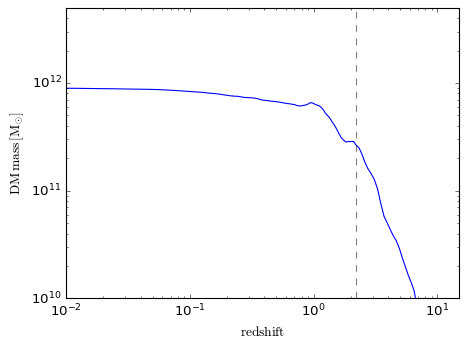

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax1.plot(t.data['reds'][first_progs_indices_main], t.data['smty'][first_progs_indices_main,1]*1e10)
for z in mergers_z:
    ax1.axvline(z, color='k', linestyle='--', alpha=0.5)
ax1.set_xlabel('$\\rm redshift $')
ax1.set_ylabel('$\\rm{DM \, mass \, [M_{\odot}]}$')
ax1.set_yscale('log')
ax1.set_xscale('log')
ax1.set_xlim(0.01,15.)
ax1.set_ylim(1e10, 5e12)

In [ ]:
"""Read the accreted particle files with a gadget_readsnap() method"""

list_directory = './lists/accretedstardata/%s/'%simulation_list[sim_id]
s.read_starparticle_mergertree_data_hdf5(snap_id, list_directory,'')
print(s.mdata)

1243210 in-situ and 134233 ex-situ stars found
{'Insitu': {'Npart': np.int64(1243210), 'ParticleIDs': array([8796103092592, 8796103103017, 8796097567455, ..., 8796151453313,
       8796157324225, 8796158545672], shape=(1243210,), dtype=uint64)}, 'Exsitu': {'Npart': np.int64(134233), 'AccretedFlag': array([0, 0, 1, ..., 1, 1, 1], shape=(134233,), dtype=int32), 'BirthFoFindex': array([16, 11,  8, ...,  0,  0,  0], shape=(134233,), dtype=int32), 'BirthSubhaloindex': array([ 16,  18, 408, ...,   1,   1,   1], shape=(134233,), dtype=int32), 'ParticleIDs': array([8796088183805, 8796088189736, 6814655006951, ..., 8796160929001,
       8796160951958, 8796160968782], shape=(134233,), dtype=uint64), 'PeakMassIndex': array([31310,  5356,   491, ...,   491,   491,   491],
      shape=(134233,), dtype=int32), 'RootIndex': array([131162,  10164,  12514, ...,    491,    491,    491],
      shape=(134233,), dtype=int32), 'BoundFirstTime': array([10.690971 ,  4.4169116, -1.       , ..., -1.       , -1.

In [ ]:
first_prog = np.array(sorted(set(list(s.mdata['Exsitu']['PeakMassIndex']))))
print('first_prog=',first_prog,len(first_prog))
"""Count the number of star particles that are now bound to the main halo from each progenitor system, and sort in descending order of mass"""
nstars_in_subhalo = np.zeros(len(first_prog))
for i, pid in enumerate(first_prog):
    nstars_in_subhalo[i] = np.sum( (s.mdata['Exsitu']['PeakMassIndex']==pid) & (s.mdata['Exsitu']['AccretedFlag']==0))

print('finished finding stars for each progenitor.')
nsort = np.argsort(nstars_in_subhalo)[::-1]
nstars_in_subhalo = nstars_in_subhalo[nsort].astype('int')
first_prog = first_prog[nsort]
print('first_prog=',first_prog,len(first_prog))
print('nstars_in_subhalo=',nstars_in_subhalo)

first_prog= [    -1    478    491    862   2660   4565   5356   7670  10262  10541
  10554  13667  17820  18324  18549  19387  19389  19750  19936  20094
  31310 244952] 22
finished finding stars for each progenitor.
first_prog= [ 10541   5356  13667  19387  10262  17820    491     -1    478  19750
  19389  10554  18324  20094  18549   4565 244952   7670  19936  31310
   2660    862] 22
nstars_in_subhalo= [13897 10841 10396  7893  5261  4989  1139   881   653   602   537   519
    70    40    17     6     2     2     1     1     0     0]


/tmp/ipykernel_566674/1738278977.py:4: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  id_index_prog, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_firstprog] ) )
/tmp/ipykernel_566674/1738278977.py:8: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  c_index, = np.where( np.in1d(s.mdata['Exsitu']['ParticleIDs'][index_firstprog], s.data['id']) )


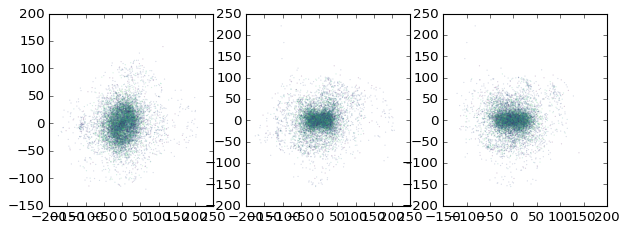

In [ ]:
"""Select 3rd most massive progenitor that merged with the MW"""
index = 2
index_firstprog, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[index] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
id_index_prog, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_firstprog] ) )
prog_star_positions = s.data['pos'][id_index_prog]

snapfb_thisprog = s.mdata['Exsitu']['BoundFirstTime'][index_firstprog]
c_index, = np.where( np.in1d(s.mdata['Exsitu']['ParticleIDs'][index_firstprog], s.data['id']) )
isort2 = np.argsort(s.mdata['Exsitu']['ParticleIDs'][ index_firstprog ][c_index])
pcolors = ( snapfb_thisprog[c_index[isort2]] - snapfb_thisprog.min() ) / ( snapfb_thisprog.max() - snapfb_thisprog.min() )

fig, ax = plt.subplots(1, 3, figsize=(9, 3))
ax[0].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,2]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[1].scatter( prog_star_positions[:,1]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
ax[2].scatter( prog_star_positions[:,2]*1e3, prog_star_positions[:,0]*1e3, c=pcolors, s=5., marker='.', linewidth=0, cmap=plt.get_cmap('viridis'), alpha=0.2 )
fig.show()

/tmp/ipykernel_566674/1702375443.py:2: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_accreted] ) )
/tmp/ipykernel_566674/1702375443.py:12: DeprecationWarning: `in1d` is deprecated. Use `np.isin` instead.
  id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_insat] ) )


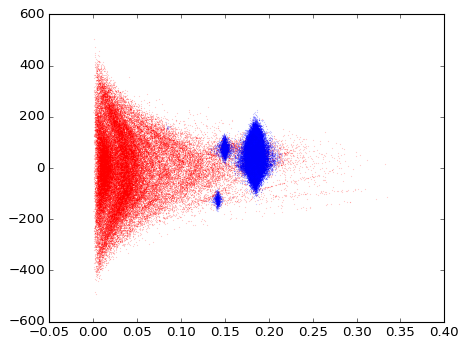

In [ ]:
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_accreted] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii

fig, ax = plt.subplots(1, 1, figsize=(6, 4.5), tight_layout=True)
ax.scatter( radii, radial_velocities, c='r', s=5, marker='.', linewidth=0, alpha=0.2 )

index_insat, = np.where((s.mdata['Exsitu']['AccretedFlag']==1))
id_index, = np.where( np.in1d( s.data['id'], s.mdata['Exsitu']['ParticleIDs'][index_insat] ) )
prog_star_positions = s.data['pos'][id_index]
prog_star_velocities = s.data['vel'][id_index]
radii = np.sqrt( np.sum(prog_star_positions**2, axis=1) )
radial_velocities = np.sum(prog_star_positions * prog_star_velocities, axis=1) / radii
ax.scatter( radii, radial_velocities, c='b', s=5, marker='.', linewidth=0, alpha=0.2 )

Doing progenitor 0 of 22
There are 27 unique root ids
Doing progenitor 1 of 22
There are 39 unique root ids
Doing progenitor 2 of 22
There are 19 unique root ids
Doing progenitor 3 of 22
There are 9 unique root ids
Doing progenitor 4 of 22
There are 8 unique root ids


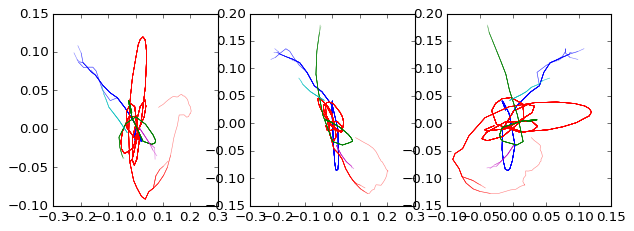

In [ ]:
fig2, ax2 = plt.subplots(1, 3, figsize=(9, 3))
colors = ['b', 'r', 'g', 'c', 'm', 'purple']
linecolorindex = 0
for i in range(5):
    index_firstprog0, = np.where( ( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[i] ) & (s.mdata['Exsitu']['AccretedFlag'] == 0) )
    rootids = s.mdata['Exsitu']['RootIndex'][ index_firstprog0 ]
    print('Doing progenitor %d of %d'%(i,len(first_prog)))
    print('There are %d unique root ids'%len(np.unique(rootids)))
    for j,rootid in enumerate(np.unique(rootids)):
        desc = rootid
        xpos = []
        ypos = []
        zpos = []
        desc_list = []
        while t.data['desc'][desc] != -1:
            if t.data['desc'][desc] == first_progs_indices_main[ snap_numbers_main==t.data['snum'][t.data['desc'][desc]] ]:# and desc != -1:
                #print('Breaking loop for desc=',desc)
                break
            desc = t.data['desc'][desc]
            desc_list.append(desc)
            main_index, = np.where( snap_numbers_main == t.data['snum'][desc] )
            try:
                    xpos.append(t.data['spos'][desc][2] - t.data['spos'][first_progs_indices_main[main_index]][0][2])
                    ypos.append(t.data['spos'][desc][1] - t.data['spos'][first_progs_indices_main[main_index]][0][1])
                    zpos.append(t.data['spos'][desc][0] - t.data['spos'][first_progs_indices_main[main_index]][0][0])
            except:
                    pass
        ax2[0].plot( ypos, xpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[1].plot( ypos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
        ax2[2].plot( xpos, zpos, color=colors[linecolorindex%len(colors)], alpha=0.5, lw=0.5 )
    linecolorindex += 1

In [ ]:
gc_cand = (((1e10*s.data['imcl'][starparts][mask_cluster_final])>1e5).any(axis=1)) * (decomp_labels[mask_cluster_final] == sph_label)

In [ ]:
gcinsitu_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Insitu']['ParticleIDs']) )
index_accreted, = np.where((s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted]) )

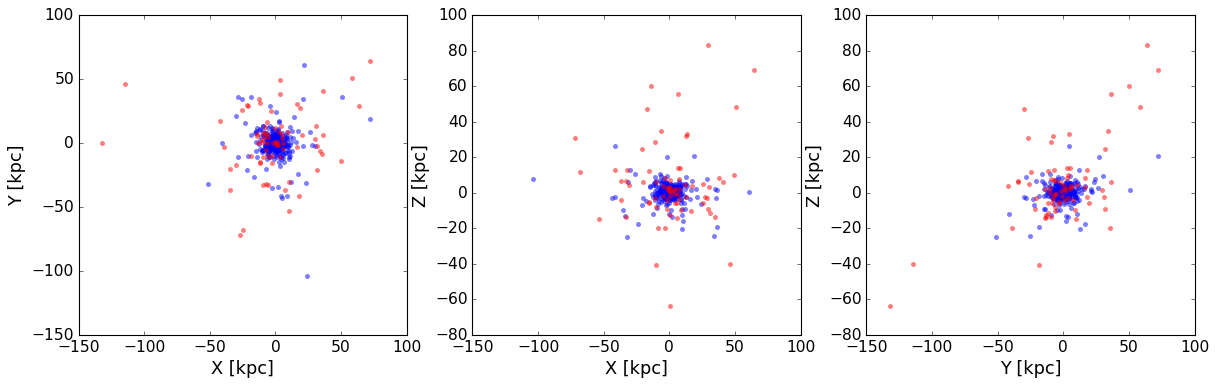

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18,5))
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,2],
                  alpha=0.5, linewidth=0, color='b')
ax[0].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,2],
                  alpha=0.5, linewidth=0, color='r')
# ax[0].set_xlim(-100,100)
# ax[0].set_ylim(-100,100)
ax[0].set_xlabel('X [kpc]', fontsize=16)
ax[0].set_ylabel('Y [kpc]', fontsize=16)
ax[0].tick_params(axis='both', which='both', labelsize=14)
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,0],
                  alpha=0.5, linewidth=0, color='b')
ax[1].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,2], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,0],
                  alpha=0.5, linewidth=0, color='r')
# ax[1].set_xlim(-100,100)
# ax[1].set_ylim(-100,100)
ax[1].set_xlabel('X [kpc]', fontsize=16)
ax[1].set_ylabel('Z [kpc]', fontsize=16)
ax[1].tick_params(axis='both', which='both', labelsize=14)
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index,0],
                    alpha=0.5, linewidth=0, color='b')
cb = ax[2].scatter(1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,1], 1e3*s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index,0],
                    alpha=0.5, linewidth=0, color='r')
# ax[2].set_xlim(-100,100)
# ax[2].set_ylim(-100,100)
ax[2].set_xlabel('Y [kpc]', fontsize=16)
ax[2].set_ylabel('Z [kpc]', fontsize=16)
ax[2].tick_params(axis='both', which='both', labelsize=14)

In [ ]:
insitu_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcinsitu_index]**2, axis=1))
exsitu_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand][gcexsitu_index]**2, axis=1))
all_radii = np.sqrt(np.sum(s.data['pos'][s.data['type']==4][starparts][mask_cluster_final][gc_cand]**2, axis=1))

/tmp/ipykernel_566674/258988237.py:20: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu), linewidth=2, label='In-situ GCs', color='k')
/tmp/ipykernel_566674/258988237.py:21: RuntimeWarning: invalid value encountered in divide
  ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu), linewidth=2, label='Ex-situ GCs', color='r')


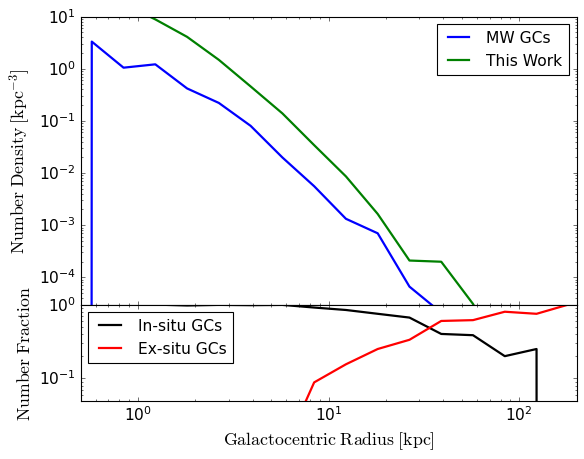

In [ ]:
mw_radii = mw_catalogue[:,2]
gc_radii = np.repeat(1e3*s.r()[s.data['type']==4][starparts][mask_cluster_initial],s.data['incl'][starparts][mask_cluster_initial])[(mclus_i>1e5) * (labels_i==sph_label) * (mclus_m>0)]
bins = np.logspace(-1, 2.5, 22)
mw_hist, _ = np.histogram(mw_radii, bins=bins)
mw_density = mw_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))
gc_hist, _ = np.histogram(gc_radii, bins=bins)
gc_density = gc_hist / (4.*np.pi*( (bins[1:]**3 - bins[:-1]**3)/3. ))

N_insitu, _ = np.histogram(1e3*insitu_radii, bins=bins)
N_exsitu, _ = np.histogram(1e3*exsitu_radii, bins=bins)

fig, ax = plt.subplots(2, 1, sharex=True, height_ratios=[3,1])
ax[0].loglog((bins[1:] + bins[:-1]) / 2., mw_density, linewidth=2, label='MW GCs')
ax[0].loglog((bins[1:] + bins[:-1]) / 2., gc_density, linewidth=2, label='This Work')
ax[0].set_ylim(3e-5, 1e1)
ax[0].set_ylabel(r'$\mathrm{Number \; Density \; [kpc^{-3}]}$', fontsize=16)
ax[0].legend(fontsize=14)
ax[0].tick_params(axis='both', which='both', labelsize=14)

ax[1].loglog((bins[1:]+bins[:-1])/2., N_insitu/(N_insitu + N_exsitu), linewidth=2, label='In-situ GCs', color='k')
ax[1].loglog((bins[1:]+bins[:-1])/2., N_exsitu/(N_insitu + N_exsitu), linewidth=2, label='Ex-situ GCs', color='r')
ax[1].set_ylabel(r'$\rm{Number \; Fraction}$', fontsize=16)
ax[1].legend(loc='upper left', fontsize=14)
ax[1].tick_params(axis='both', which='both', labelsize=14)
ax[1].set_xlabel(r'$\mathrm{Galactocentric \; Radius \; [kpc]}$', fontsize=16)
ax[1].set_xlim(5e-1, 2e2)
ax[1].set_ylim(5e-2, 1)

plt.subplots_adjust(hspace=0.0)
# plt.savefig('./plots/insitu_exsitu_gcs_paper.pdf', bbox_inches='tight')

In [ ]:
index_accreted_1p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[0] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_1p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_1p] ) )
index_accreted_2p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[1] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_2p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_2p] ) )
index_accreted_3p, = np.where(( s.mdata['Exsitu']['PeakMassIndex'] == first_prog[2] ) & (s.mdata['Exsitu']['AccretedFlag']==0))
gcexsitu_3p_index, = np.where( np.isin( s.data['id'][s.data['type']==4][starparts][mask_cluster_final][gc_cand], s.mdata['Exsitu']['ParticleIDs'][index_accreted_3p] ) )

(6.0, 14.0)

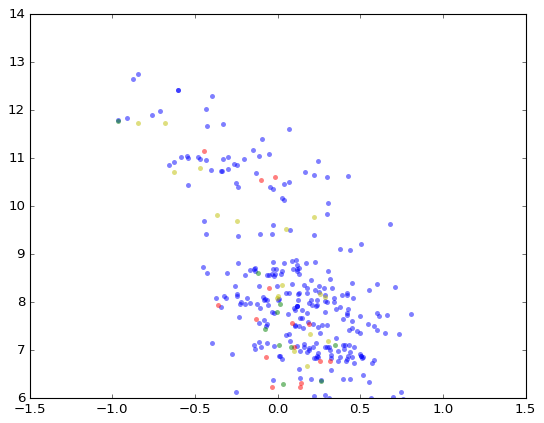

In [ ]:
plt.scatter(feh_scs[gcinsitu_index], clus_age[gcinsitu_index], c='b', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_1p_index], clus_age[gcexsitu_1p_index], c='r', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_2p_index], clus_age[gcexsitu_2p_index], c='y', linewidths=0, alpha=0.5)
plt.scatter(feh_scs[gcexsitu_3p_index], clus_age[gcexsitu_3p_index], c='g', linewidths=0, alpha=0.5)
plt.ylim(6,14)